In [30]:
import SimDAT2D.SimDAT2D as sim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IsoDAT2D.IsoDAT2D as iso
from PIL import Image
import pyFAI, fabio
from pyFAI.gui import jupyter
import pyFAI
import os
import matplotlib.pyplot as plt
from tifffile import imread
from SimDAT2D import masking
import pyFAI.azimuthalIntegrator as AI
from scipy.ndimage import shift
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

In [9]:
def create_mask_for_tiff(tiff_path, width):
    """
    This function creates a mask for the azimuthal integrator from a TIFF file.
    
    Parameters:
        tiff_path (str): Path to the TIFF file
        width (int): The width of the line of interest
    """
    # Import tiff file
    from tifffile import imread
    image = imread(tiff_path)
    
    # Get the center point (assuming square image)
    center = image.shape[0] // 2
    
    # Create the mask
    mask = np.ones_like(image)
    mask[center-width:center+width, center:] = 0
    
    # Display the mask
    plt.figure(figsize=(5, 5))
    plt.imshow(mask, cmap='viridis')
    plt.title("Mask")
    plt.show()
    
    return mask

In [10]:
def read_poni_file(poni_file):
    """
    This function reads a .poni file and extracts the distance and wavelength, rotation, and poni from the file.
    
    Parameters:
        poni_file (str): The path to the .poni file.
    """
    #read the .poni file and extract the distance and wavelength from the file
    with open(poni_file, 'r') as file:
        for line in file:
            if 'Distance:' in line:
                distance = float(line.split()[1])
            if 'Wavelength:' in line:
                wavelength = float(line.split()[1])
            if 'Rot1:' in line:
                rot1 = float(line.split()[1])
            if 'Rot2:' in line:
                rot2 = float(line.split()[1])
            if 'Rot3:' in line:
                rot3 = float(line.split()[1])
            if 'Poni1:' in line:
                poni1 = float(line.split()[1])
            if 'Poni2:' in line:
                poni2 = float(line.split()[1])
    
    return distance, wavelength, rot1, rot2, rot3, poni1, poni2

poni_file = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\perkin\Ni_calib.poni'

In [11]:
#Create a function that takes the combined image and integrates it using the azimuthal integrator and displays the 1D image
def integrate_image(combined_image, distance, wavelength, resolution = 3000, mask = None, center = None, show = False, radial_range = (0,15)):
    """
    This function integrates the combined image using the azimuthal integrator and displays the 1D image.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
    """
    #initialize the azimuthal integrator
    if center is None:
        center = (combined_image.shape[1]//2, combined_image.shape[0]//2)
     # Initialize the detector
    dete = pyFAI.detectors.Perkin()
    p1, p2, p3 = dete.calc_cartesian_positions()
    poni1 = read_poni_file(poni_file)[5]
    poni2 = read_poni_file(poni_file)[6]

    ai = AI.AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
    
    #integrate the combined image using the azimuthal integrator
    q, I = ai.integrate1d(combined_image, resolution, radial_range = radial_range, unit = 'q_A^-1', mask = mask)
    
    if show == True:
        #plot the 1D image
        plt.figure(figsize=(10, 10))
        plt.plot(q, I)
        plt.title("1D X-Ray Diffraction Image")
        plt.show()
    
    return q, I

In [12]:
def image_rotation(image, angle, show = False, center = None):
    """
    This function rotates the combined image by a user specified angle amount, if the angle specified is 1, the result is that the combined image is rotated by one degree.
    
    Parameters:
        image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        """
    if center is None:
        center = (image.shape[1] // 2, image.shape[0] // 2)  # (x,y) format
    pil_format = Image.fromarray(image)
    rotated_image = pil_format.rotate(angle)
    rotated_image = np.array(rotated_image)
    
    if show == True:
        #display the rotated image
        plt.figure(figsize=(10, 10))
        plt.imshow(rotated_image, cmap='viridis')
        plt.title("Rotated Image")
        plt.show()
    return rotated_image

In [13]:
def rotate_and_integrate(combined_image, angle_of_rotation, distance, wavelength, resolution = 3000, mask = None):
    """
    This function takes the combined image, the mask, the distance, the wavelength, and the resolution of integration, and rotates the combined image by a user specified angle amount, if the angle specified is 1, the result will be 360 integrations of the combined image, each integration will be rotated by 1 degree.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        distance (float): The distance from the detector to the sample.
        wavelength (float): The wavelength of the x-rays.
        resolution (int): The resolution of the integration.
        mask (2D array): The mask to use for the integration.
    """
    
    import pandas as pd 
    
    #create a dataframe to store the 1D integrations
    df = pd.DataFrame()

    # Calculate number of steps for 180 degrees
    n_steps = int(360 / angle_of_rotation)
    angles = np.linspace(0, 360, n_steps, endpoint=False)

    # Pre-allocate lists to store data
    intensity_data = []
    angle_labels = []
    
    # Create a loop that rotates the combined image
    for i, angle in enumerate(angles):
        #rotate the mask for the combined image
        rotated_image = image_rotation(combined_image, i);
        
        #integrate the rotated image
        q, I = integrate_image(rotated_image, distance, wavelength, resolution, mask, show = False);
        
        # Add the 1D integration to the dataframe
        # Store data
        intensity_data.append(I)
        angle_labels.append(f"{angle:.3f}")
        
    # Create DataFrame all at once
    df = pd.DataFrame(np.array(intensity_data).T, columns=angle_labels)
    
    #create a waterfall plot of the 1D integrations, where each dataset is moved up on the y axis by a multiple of .5
    plt.figure(figsize=(10, 10))

    for j in range(0, 180, angle_of_rotation):
            plt.plot(q, (df[j]+ j*.01), alpha = .55, c = 'black')
    plt.xlabel('q A $^(-1)$')
    plt.ylabel('Intensity')
    plt.title("Waterfall Plot of Rotated 1D X-Ray Diffraction Images")
    plt.show()        
    return q, df


In [23]:
def rotate_and_integrate_mask(combined_image, angle_of_rotation, distance, wavelength, resolution = 3000, mask = None):
    """
    This function takes the combined image, the mask, the distance, the wavelength, and the resolution of integration, 
    and rotates the mask by a user specified angle amount, if the angle specified is 1, 
    the result will be 360 integrations of the combined image with different mask orientations.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        distance (float): The distance from the detector to the sample.
        wavelength (float): The wavelength of the x-rays.
        resolution (int): The resolution of the integration.
        mask (2D array): The mask to use for the integration.
    """
    
    import pandas as pd 
    
    #create a dataframe to store the 1D integrations
    df = pd.DataFrame()

    # Calculate number of steps for 360 degrees
    n_steps = int(360 / angle_of_rotation)
    angles = np.linspace(0, 360, n_steps, endpoint=False)

    # Pre-allocate lists to store data
    intensity_data = []
    angle_labels = []
    
    # Create a loop that rotates the mask
    for i, angle in enumerate(angles):
        #rotate the mask instead of the image
        if mask is not None:
            rotated_mask = image_rotation(mask, angle)
        else:
            rotated_mask = None
        
        #integrate the image with the rotated mask
        q, I = integrate_image(combined_image, distance, wavelength, resolution, mask=rotated_mask, show=False)
        
        # Store data
        intensity_data.append(I)
        angle_labels.append(f"{angle:.3f}")
        
    # Create DataFrame all at once
    df = pd.DataFrame(np.array(intensity_data).T, columns=angle_labels)
    
    #create a waterfall plot of the 1D integrations, where each dataset is moved up on the y axis by a multiple of .5
    plt.figure(figsize=(10, 10))
    for angle in angles[1:len(angles)-1]:  # Skip first & last angles
        plt.plot(q, (df[f"{angle:.3f}"]), c='black')
    plt.xlabel('Original q (A$^{-1}$)')
    plt.ylabel('Intensity')
    plt.title("Overlay Plot")
    plt.show()     
    return q, df

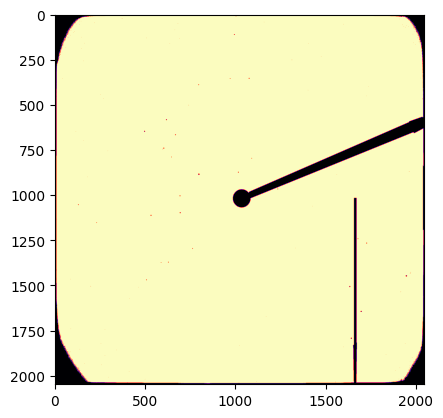

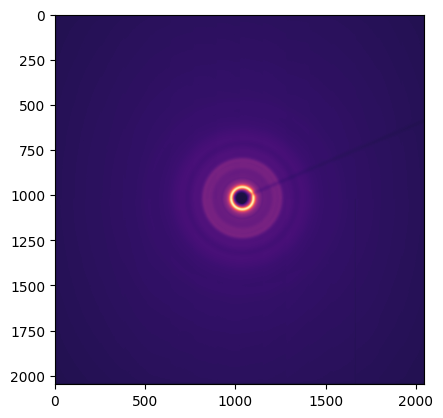

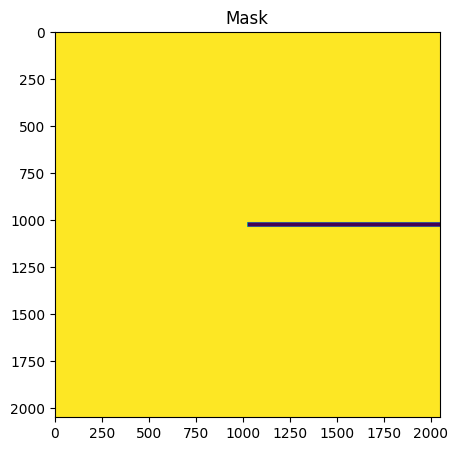

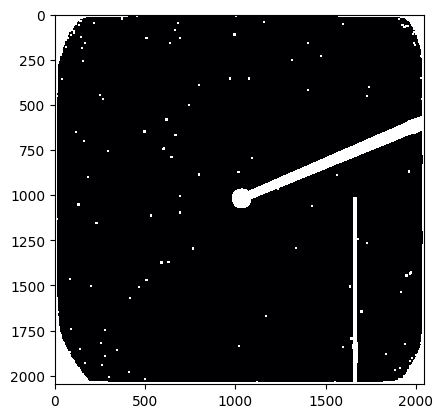

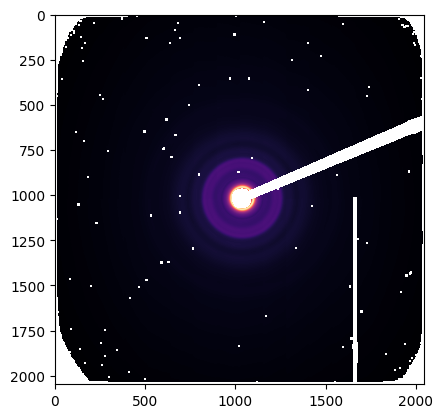

In [15]:
tm_mask_path = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\perkin\masks\tm_mask_whole.npy'
tm_mask = np.load(tm_mask_path)
tm_inverted_mask = 1 - tm_mask
plt.imshow(tm_inverted_mask, cmap = 'magma')
plt.show()

tm_cryst_C_GST_SiO2 = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\perkin\da_8_cryst_C_GST_SiO2-00008\da_8_cryst_C_GST_SiO2-00008.tiff'
tm_cryst_C_GST_SiO2_image = imread(tm_cryst_C_GST_SiO2)
plt.imshow(tm_cryst_C_GST_SiO2_image, cmap = 'magma')
plt.show()

#create integration mask
mask_12 = create_mask_for_tiff(tm_cryst_C_GST_SiO2, 12)


tm_mask_with_nan = tm_inverted_mask.astype(float)
tm_mask_with_nan[tm_inverted_mask == 0] = np.nan
plt.imshow(tm_mask_with_nan, cmap = 'magma')
plt.show()

tm_combined_image = tm_cryst_C_GST_SiO2_image + tm_mask_with_nan
plt.imshow(tm_combined_image, cmap = 'magma')
plt.show() 

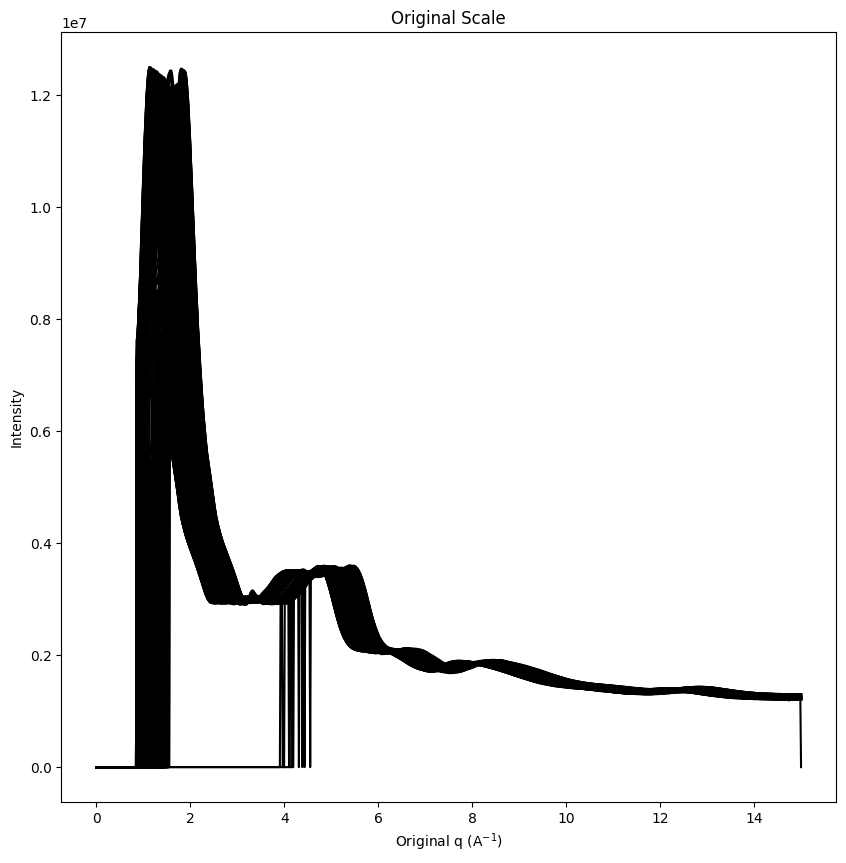

In [17]:
q, cryst_C_GST_SiO2_TM = rotate_and_integrate_mask(tm_combined_image, 5, .41794313, 1.22224e-11, resolution = 1000, mask = mask_12)

Cleaned image:
Shape: (2048, 2048)
Min value: nan
Max value: nan
Number of non-zero pixels: 4194304

Shifted image:
Shape: (2048, 2048)
Min value: nan
Max value: nan
Number of non-zero pixels: 4194304


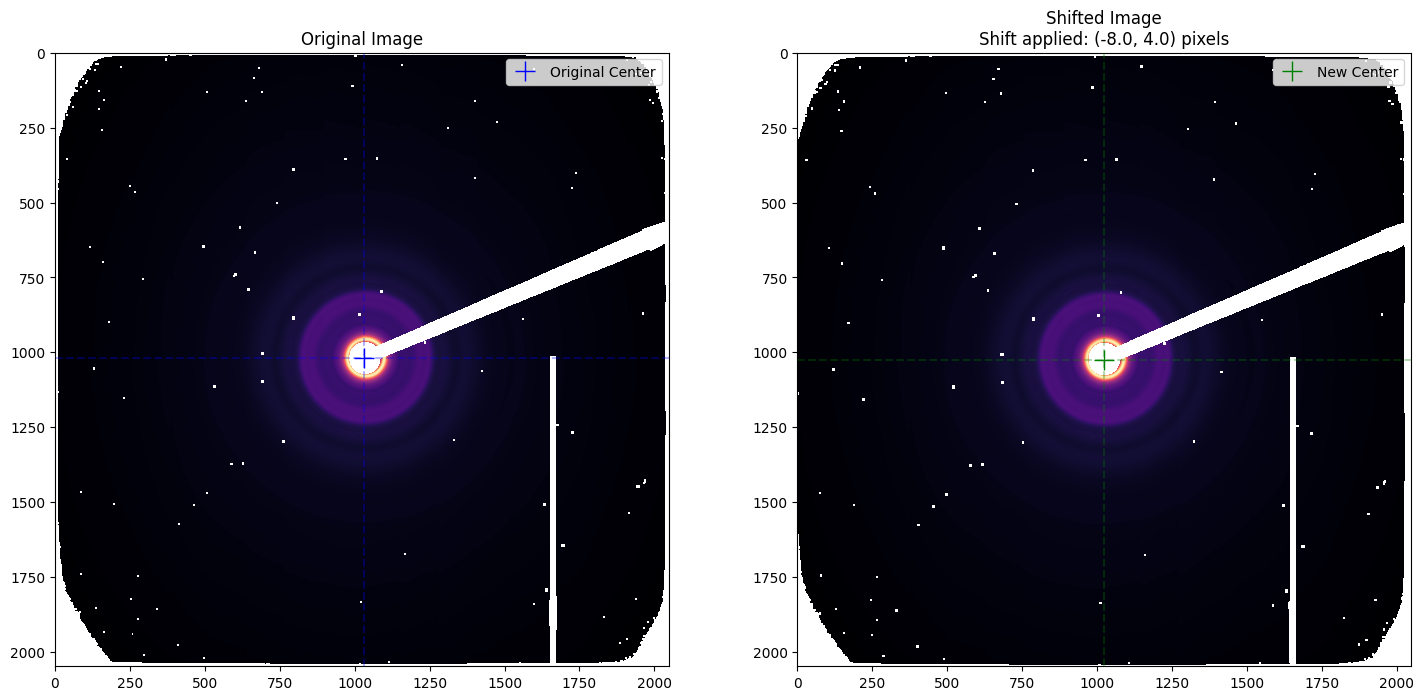

Shift applied: dx=-8.0, dy=4.0 pixels
(2048, 2048)


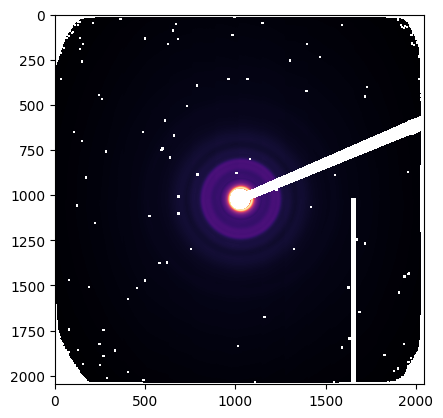

In [20]:
def center_shift_image(image, current_center, target_center=(1024,1024)):
    """
    Shift image to move current_center to target_center
    
    Parameters:
        image: 2D numpy array of the image data
        current_center: tuple (x,y) of current beam center
        target_center: tuple (x,y) of desired center (default: (1024,1024))
    
    Returns:
        shifted_image: 2D numpy array of shifted image
        shift_applied: tuple (dx,dy) of the applied shift
    """
    # # First, let's check and clean the input image
    # cleaned_image = np.copy(image)
    
    # # Replace NaN values with 0 or the mean of non-NaN values
    # if np.any(np.isnan(cleaned_image)):
    #     print("Found NaN values in original image, replacing with 0")
    #     cleaned_image = np.nan_to_num(cleaned_image, nan=0.0)

    # Calculate required shift
    dx = target_center[0] - current_center[0]
    dy = target_center[1] - current_center[1]
    
    # Print diagnostic information about cleaned image
    print("Cleaned image:")
    print(f"Shape: {image.shape}")
    print(f"Min value: {np.min(image)}")
    print(f"Max value: {np.max(image)}")
    print(f"Number of non-zero pixels: {np.count_nonzero(image)}")
    
    # Shift with cleaned image
    shifted_image = shift(image, (dy, dx), mode='reflect', order=1)
    
    # Print diagnostic information about shifted image
    print("\nShifted image:")
    print(f"Shape: {shifted_image.shape}")
    print(f"Min value: {np.min(shifted_image)}")
    print(f"Max value: {np.max(shifted_image)}")
    print(f"Number of non-zero pixels: {np.count_nonzero(shifted_image)}")
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original image
    im1 = ax1.imshow(image, cmap='magma')
    ax1.plot(current_center[0], current_center[1], 'b+', markersize=15, label='Original Center')
    ax1.axhline(y=current_center[1], color='b', linestyle='--', alpha=0.3)
    ax1.axvline(x=current_center[0], color='b', linestyle='--', alpha=0.3)
    ax1.set_title('Original Image')
    ax1.legend()
    #plt.colorbar(im1, ax=ax1)
    
    # Shifted image
    im2 = ax2.imshow(shifted_image, cmap='magma')
    ax2.plot(target_center[0], target_center[1], 'g+', markersize=15, label='New Center')
    ax2.axhline(y=target_center[1], color='g', linestyle='--', alpha=0.3)
    ax2.axvline(x=target_center[0], color='g', linestyle='--', alpha=0.3)
    ax2.set_title(f'Shifted Image\nShift applied: ({dx:.1f}, {dy:.1f}) pixels')
    ax2.legend()
    #plt.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Shift applied: dx={dx:.1f}, dy={dy:.1f} pixels")
    
    return shifted_image, (dx, dy)

# Define current beam center
current_center = (1032, 1020)  

# Apply the shift
tm_shifted_image, shift_applied = center_shift_image(
    image=tm_combined_image,
    current_center=current_center,
    target_center=(1024, 1024)
)
print(tm_combined_image.shape)
plt.imshow(tm_shifted_image, cmap = 'magma')
plt.show()


(2048, 2048)


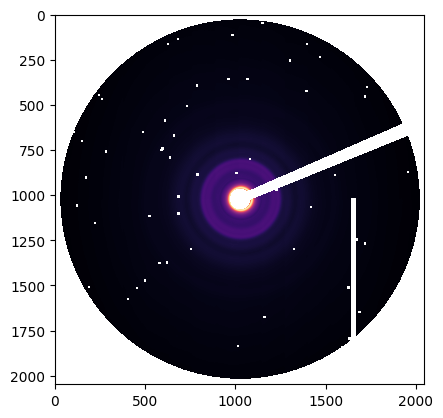

(2048, 2048)


In [21]:
def fill_with_circle(image, radius=None, center=None):
    """
    Fill NaN values with the mean of neighboring non-NaN pixels, but only within
    a circular region defined by radius and center
    
    Parameters:
    image: 2D numpy array
    radius: radius of circle (default: min(height,width)/2)
    center: (y,x) coordinates of circle center (default: image center)
    """
    # Create a copy of the image
    filled_image = np.copy(image)
    
    # Set defaults if not provided
    if center is None:
        center = (image.shape[0]//2, image.shape[1]//2)  # (y, x)
    if radius is None:
        radius = min(image.shape[0], image.shape[1])//2
        
    # Create a circular mask
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    dist_from_center = np.sqrt((y - center[0])**2 + (x - center[1])**2)
    circle_mask = dist_from_center <= radius 
    # Set all pixels outside circle to NaN
    filled_image[~circle_mask] = np.nan
    
    return filled_image

print(tm_shifted_image.shape)
tm_circle = fill_with_circle(tm_shifted_image, radius = 1000, center = (1024, 1024))
plt.imshow(tm_circle, cmap = 'magma')
plt.show()
print(tm_circle.shape)

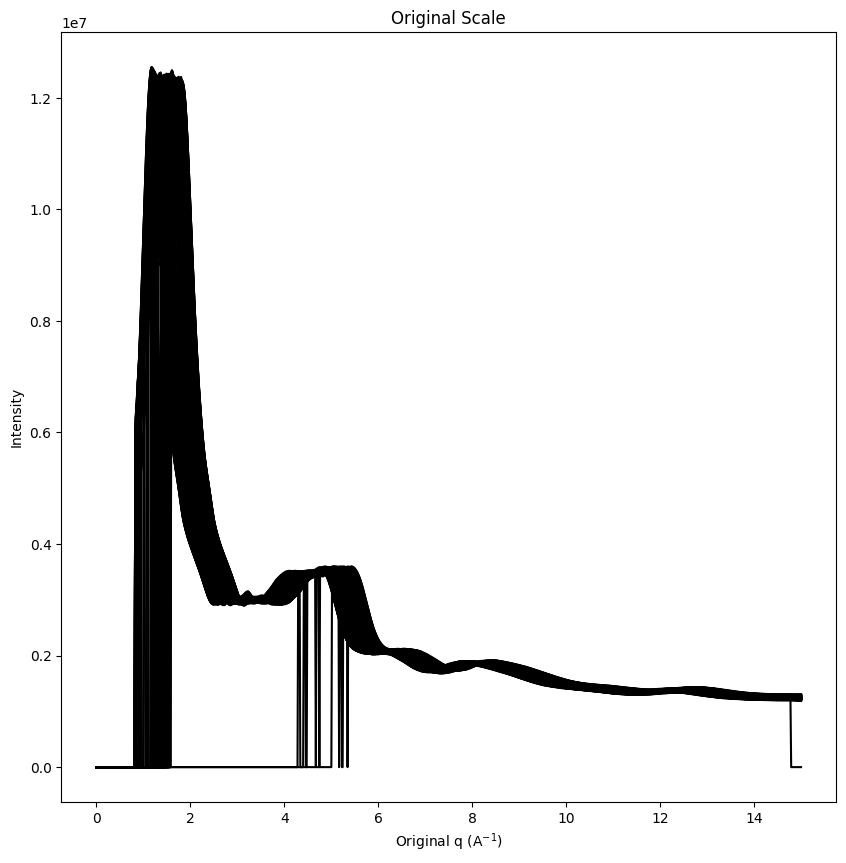

In [22]:
q, cryst_C_GST_SiO2_TM = rotate_and_integrate_mask(tm_circle, 5, .41794313, 1.22224e-11, resolution = 1000, mask = mask_12)

In [28]:
def rotate_and_integrate_maskdebug(combined_image, angle_of_rotation, distance, wavelength, resolution=3000, mask=None, 
                         intermediate_steps=18): 
    """
    This function takes the combined image, the mask, the distance, the wavelength, and the resolution of integration, 
    and rotates the mask by a user specified angle amount, if the angle specified is 1, 
    the result will be 360 integrations of the combined image with different mask orientations.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        distance (float): The distance from the detector to the sample.
        wavelength (float): The wavelength of the x-rays.
        resolution (int): The resolution of the integration.
        mask (2D array): The mask to use for the integration.
        visualization_steps (int): How many intermediate visualizations to show (will plot every n steps)
    """
    
    import pandas as pd 
    
    print(f"Starting rotate_and_integrate function")
    
    #create a dataframe to store the 1D integrations
    df = pd.DataFrame()

    # Calculate number of steps for 360 degrees
    n_steps = int(360 / angle_of_rotation)
    angles = np.linspace(0, 360, n_steps, endpoint=False)
    
    # Determine how often to show visualizations
    visualization_interval = max(1, n_steps // intermediate_steps)
    print(f"Will show visualizations every {visualization_interval} steps")

    # Pre-allocate lists to store data
    intensity_data = []
    angle_labels = []
    
    # Create a loop that rotates the mask
    for i, angle in enumerate(angles):
        print(f"\nProcessing angle {i+1}/{n_steps}: {angle:.3f} degrees")
        
        # Rotate the mask instead of the image
        if mask is not None:
            rotated_mask = image_rotation(mask, angle)
        else:
            rotated_mask = None
        
        # Show intermediate visualizations at regular intervals
        if i % visualization_interval == 0:
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # Plot the original image
            im0 = axes[0].imshow(combined_image, cmap='magma')
            axes[0].set_title(f"Original Image")
            plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
            
            # Plot the rotated mask
            if rotated_mask is not None:
                im1 = axes[1].imshow(rotated_mask, cmap='gray')
                axes[1].set_title(f"Rotated Mask (Angle: {angle:.1f}°)")
                plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
            else:
                axes[1].text(0.5, 0.5, "No Mask", ha='center', va='center')
                axes[1].set_title("No Mask Provided")
            
            # Plot the masked image (what will be integrated)
            if rotated_mask is not None:
                # Create a visualization of the masked image
                # For visualization, set masked areas to NaN so they appear transparent
                mask_viz = rotated_mask.copy()
                if mask_viz.dtype != bool:
                    mask_viz = mask_viz.astype(bool)
                masked_image = combined_image.copy()
                masked_image[~mask_viz] = np.nan  # Areas where mask is 0 become NaN
                
                im2 = axes[2].imshow(masked_image, cmap='magma')
                axes[2].set_title(f"Image with Rotated Mask Applied")
                plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
            else:
                im2 = axes[2].imshow(combined_image, cmap='magma')
                axes[2].set_title(f"No Mask Applied")
                plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
            
            plt.tight_layout()
            plt.suptitle(f"Visualization at Step {i+1}/{n_steps} (Angle: {angle:.1f}°)", fontsize=16)
            plt.subplots_adjust(top=0.9)
            plt.show()
        
        # Integrate the image with the rotated mask
        q, I = integrate_image(combined_image, distance, wavelength, resolution, mask=rotated_mask, show=False)
        
        # Store data
        intensity_data.append(I)
        angle_labels.append(f"{angle:.3f}")
        
        # Print progress every 10% of steps
        progress_interval = max(1, n_steps // 10)
        if (i+1) % progress_interval == 0:
            print(f"Completed {i+1}/{n_steps} integrations ({(i+1)/n_steps*100:.1f}%)")
    
    # Create DataFrame all at once
    df = pd.DataFrame(np.array(intensity_data).T, columns=angle_labels)
    
    # Create a waterfall plot of the 1D integrations
    plt.figure(figsize=(10, 10))
    for angle in angles[1:len(angles)-1]:  # Skip first & last angles
        plt.plot(q, (df[f"{angle:.3f}"]), c='black')
    plt.xlabel('Original q (A$^{-1}$)')
    plt.ylabel('Intensity')
    plt.title("Overlay Plot")
    plt.show()     
    return q, df

Starting rotate_and_integrate function
Will show visualizations every 4 steps

Processing angle 1/72: 0.000 degrees


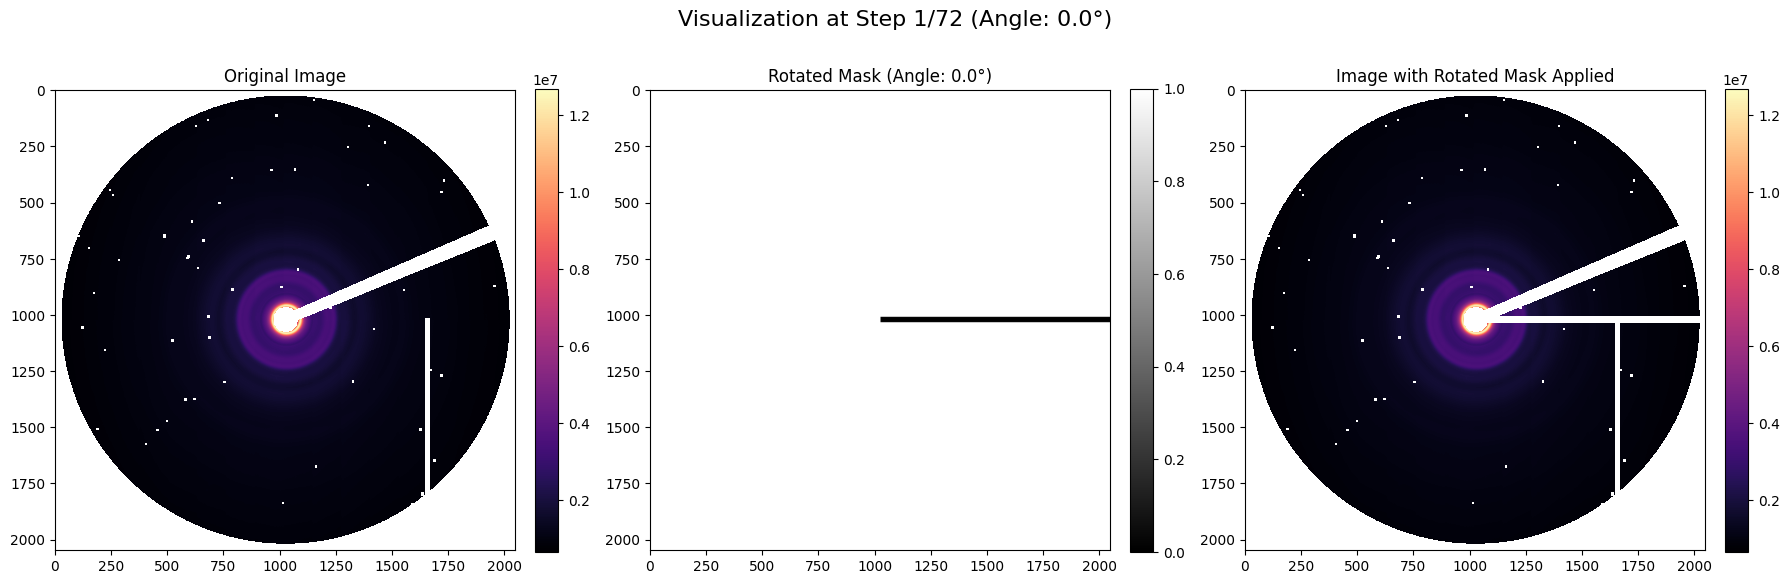


Processing angle 2/72: 5.000 degrees

Processing angle 3/72: 10.000 degrees

Processing angle 4/72: 15.000 degrees

Processing angle 5/72: 20.000 degrees


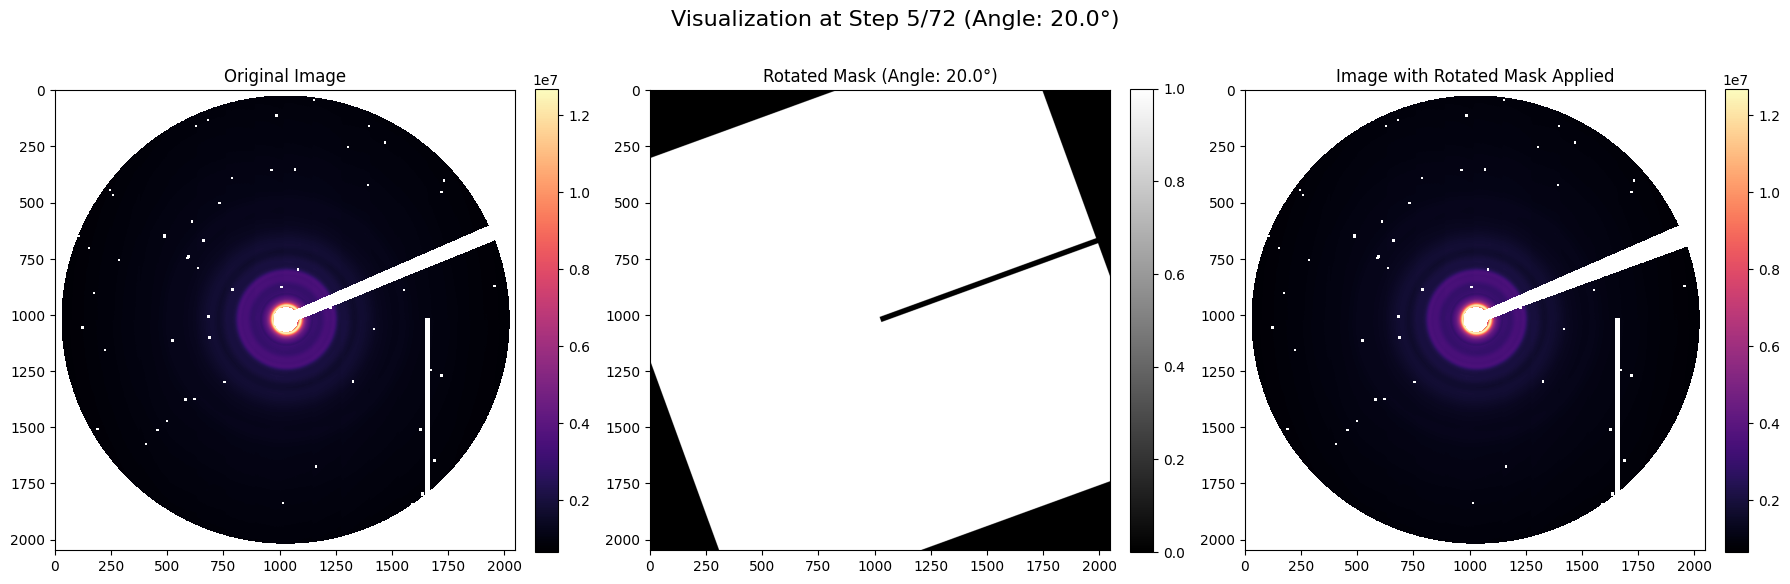


Processing angle 6/72: 25.000 degrees

Processing angle 7/72: 30.000 degrees
Completed 7/72 integrations (9.7%)

Processing angle 8/72: 35.000 degrees

Processing angle 9/72: 40.000 degrees


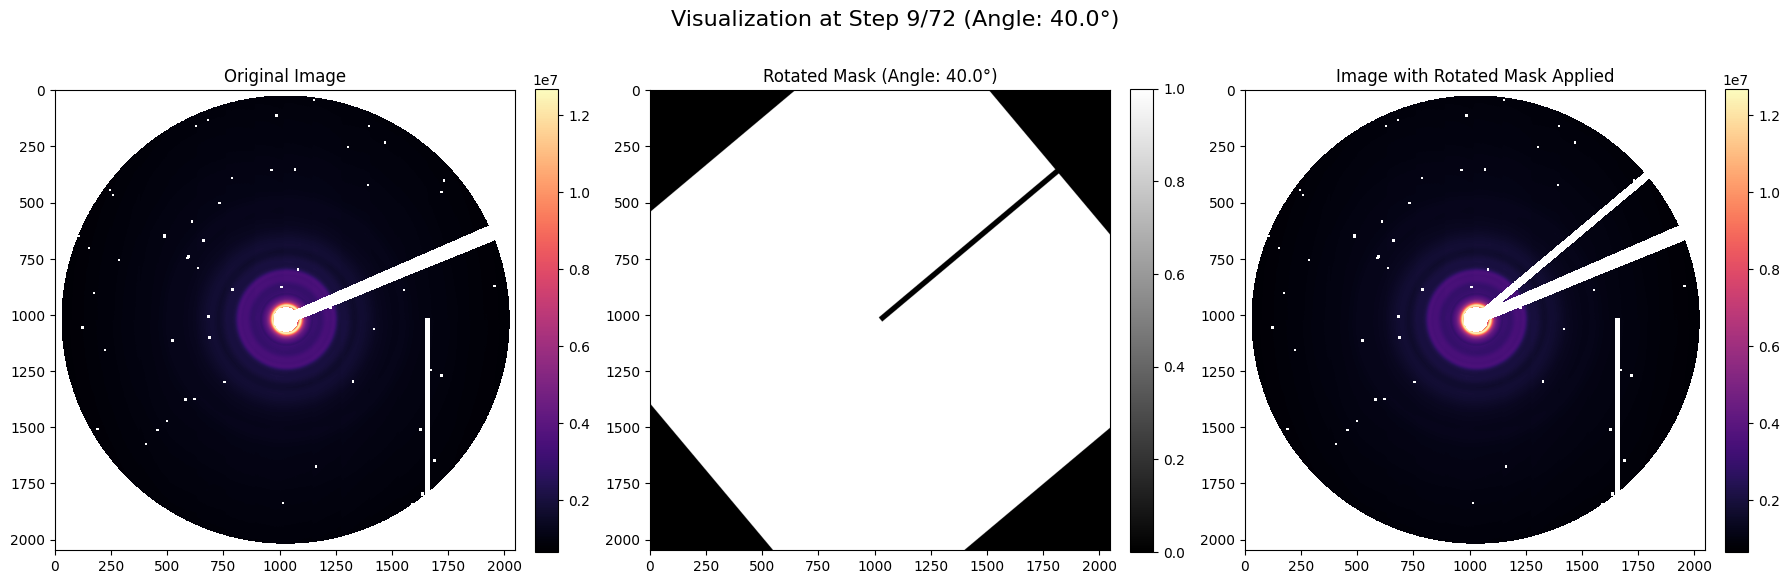


Processing angle 10/72: 45.000 degrees

Processing angle 11/72: 50.000 degrees

Processing angle 12/72: 55.000 degrees

Processing angle 13/72: 60.000 degrees


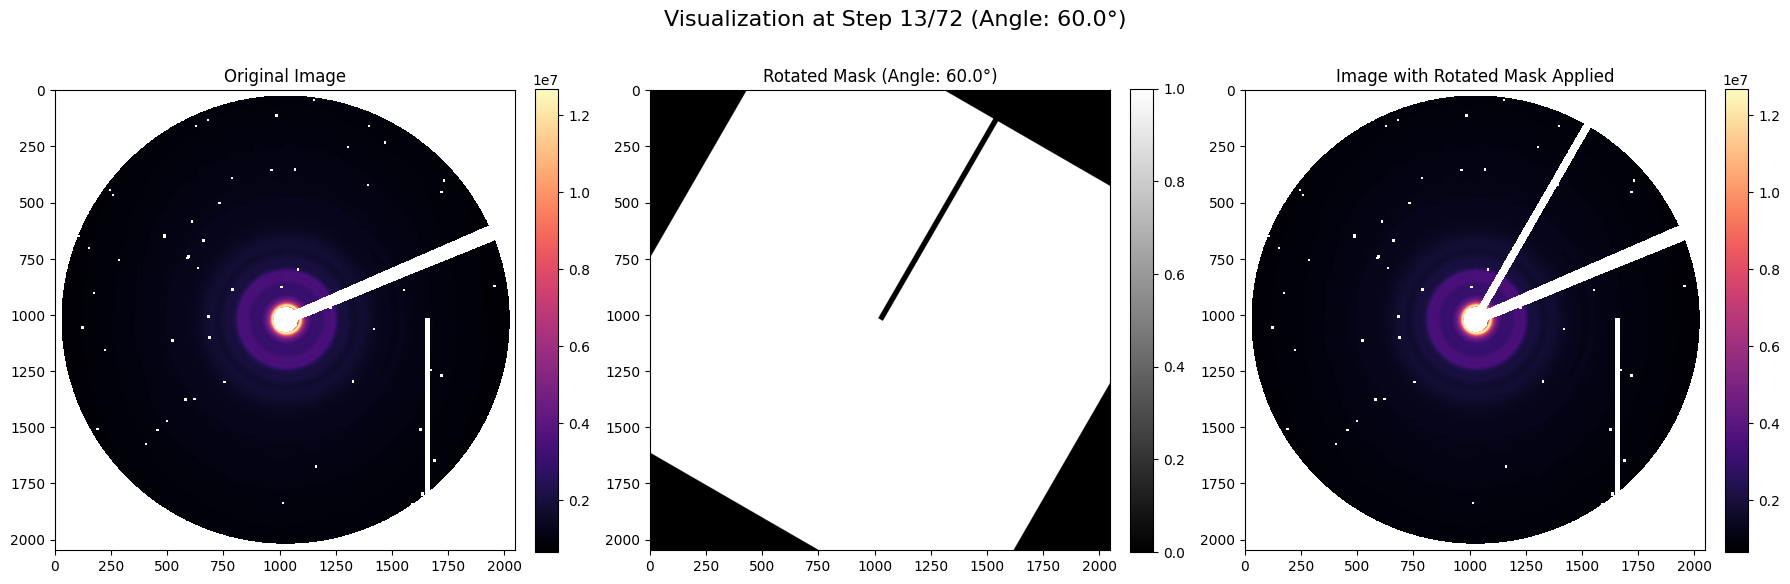


Processing angle 14/72: 65.000 degrees
Completed 14/72 integrations (19.4%)

Processing angle 15/72: 70.000 degrees

Processing angle 16/72: 75.000 degrees

Processing angle 17/72: 80.000 degrees


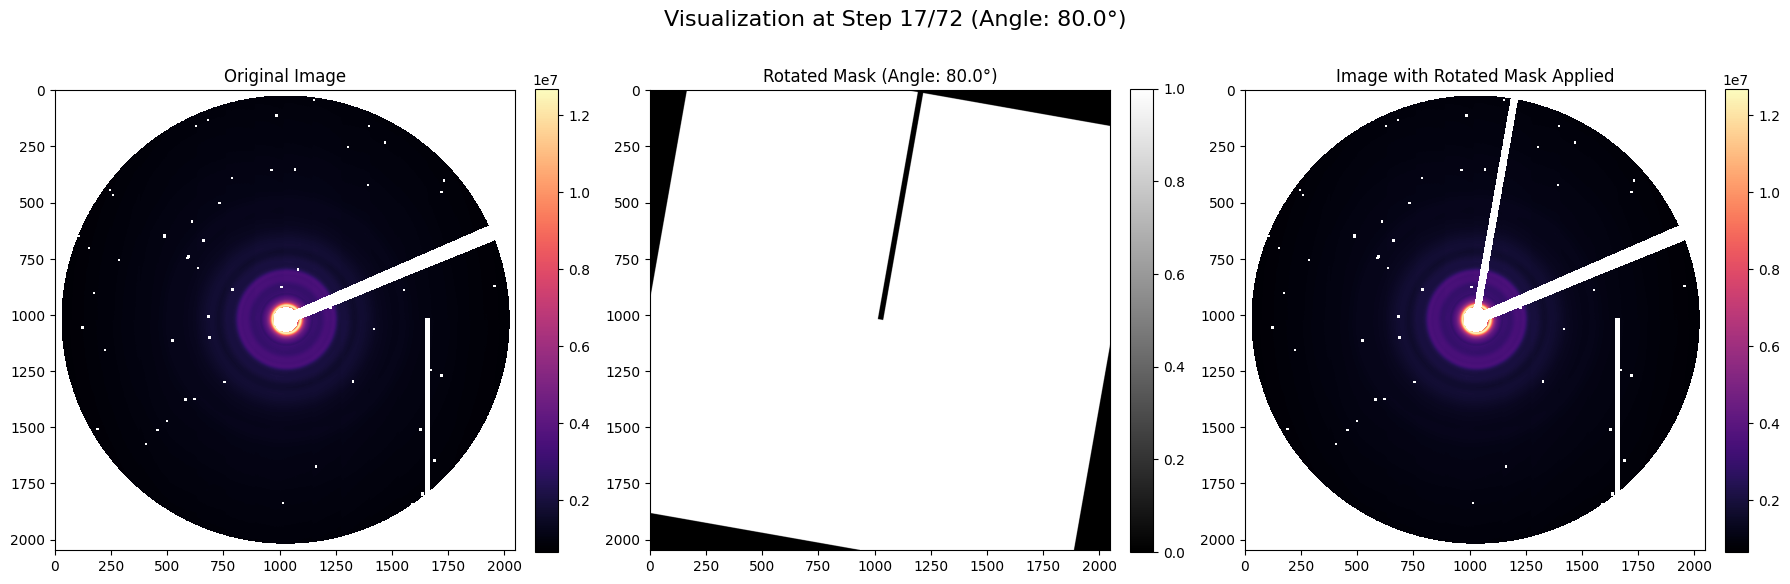


Processing angle 18/72: 85.000 degrees

Processing angle 19/72: 90.000 degrees

Processing angle 20/72: 95.000 degrees

Processing angle 21/72: 100.000 degrees


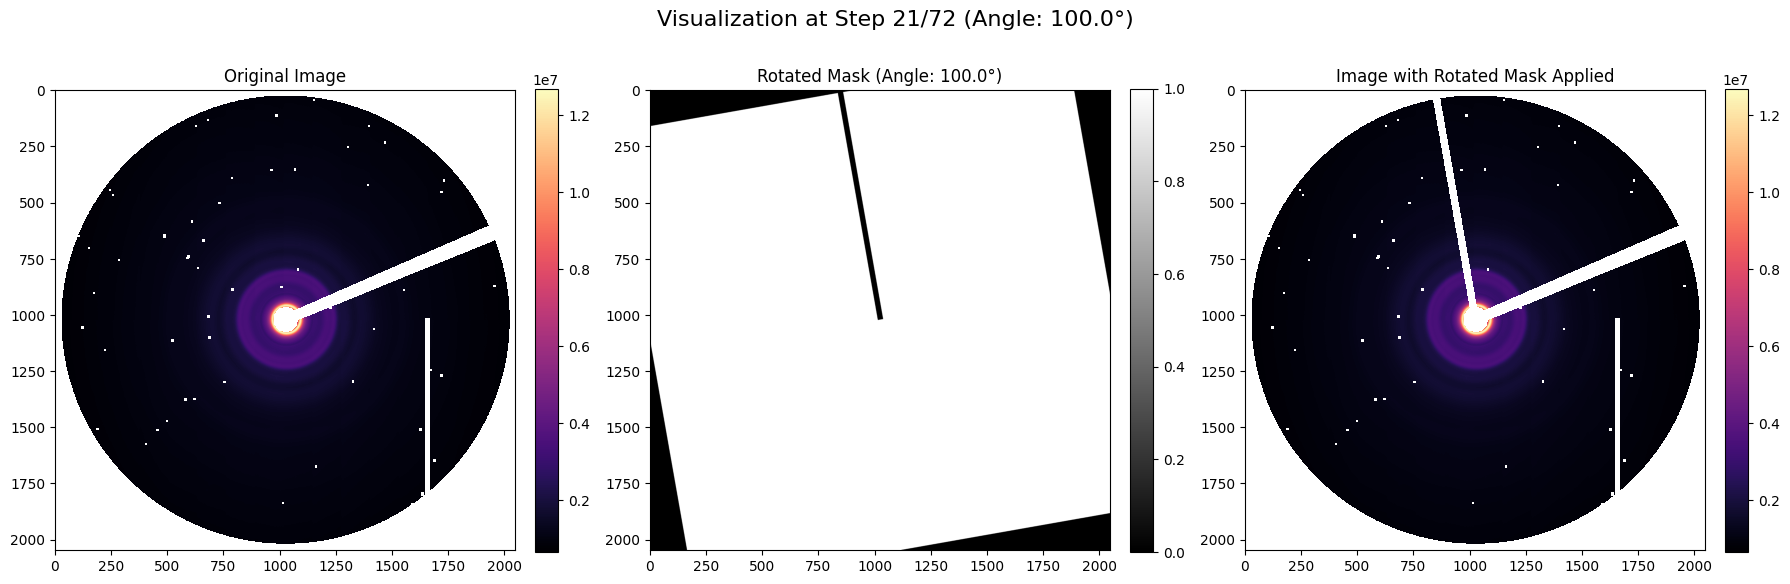

Completed 21/72 integrations (29.2%)

Processing angle 22/72: 105.000 degrees

Processing angle 23/72: 110.000 degrees

Processing angle 24/72: 115.000 degrees

Processing angle 25/72: 120.000 degrees


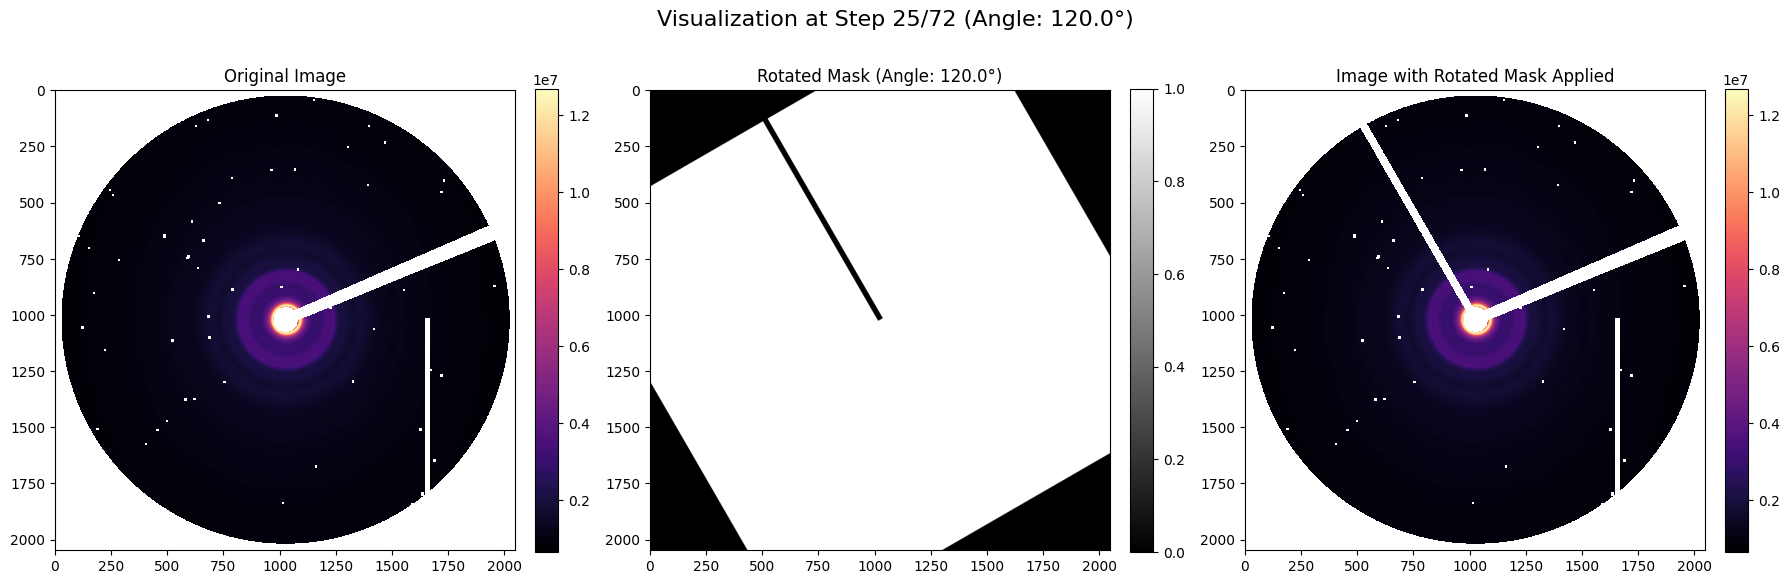


Processing angle 26/72: 125.000 degrees

Processing angle 27/72: 130.000 degrees

Processing angle 28/72: 135.000 degrees
Completed 28/72 integrations (38.9%)

Processing angle 29/72: 140.000 degrees


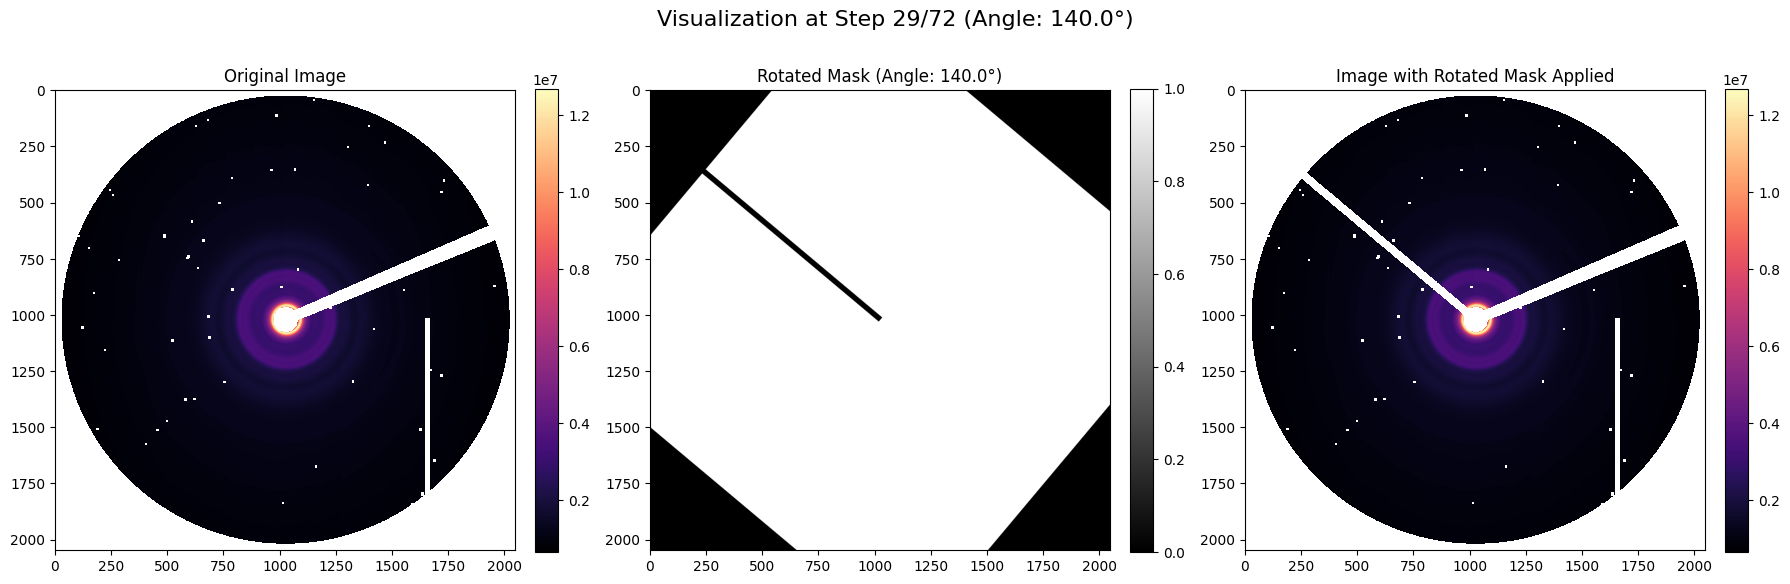


Processing angle 30/72: 145.000 degrees

Processing angle 31/72: 150.000 degrees

Processing angle 32/72: 155.000 degrees

Processing angle 33/72: 160.000 degrees


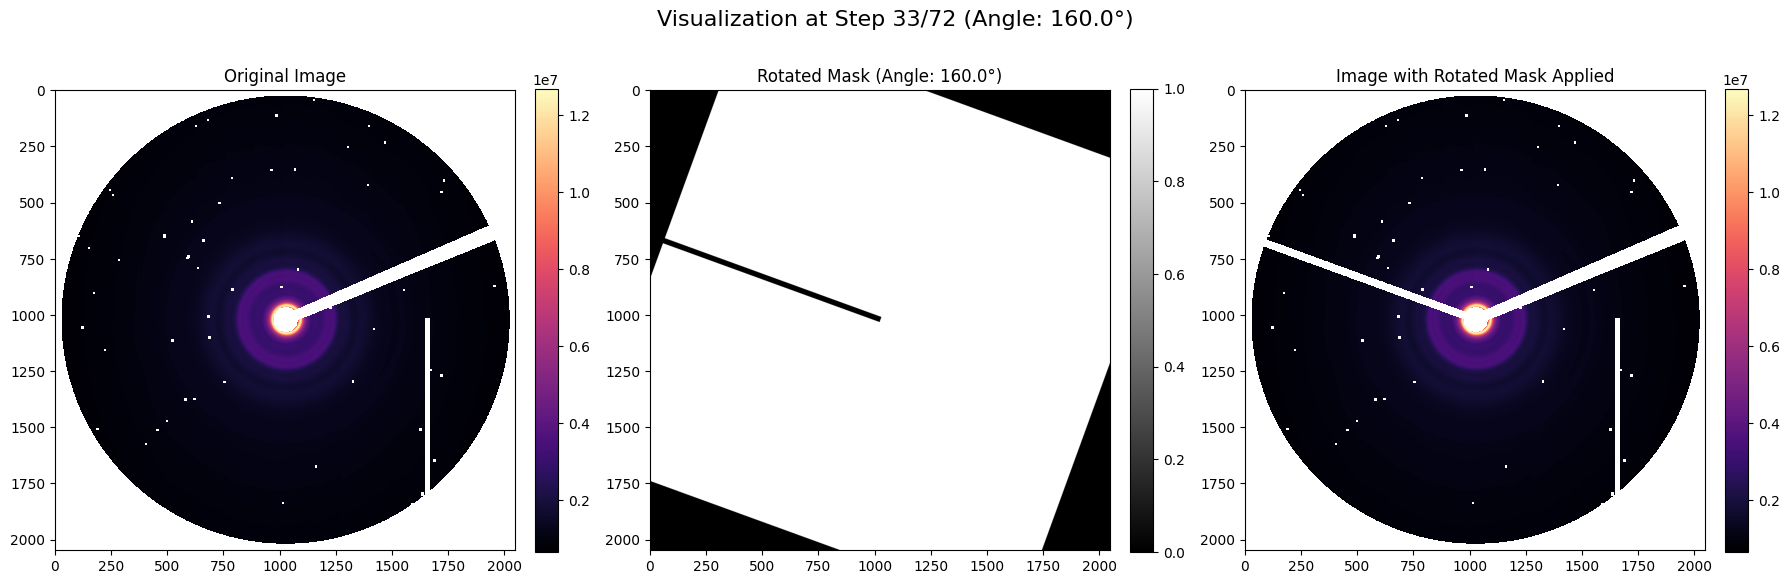


Processing angle 34/72: 165.000 degrees

Processing angle 35/72: 170.000 degrees
Completed 35/72 integrations (48.6%)

Processing angle 36/72: 175.000 degrees

Processing angle 37/72: 180.000 degrees


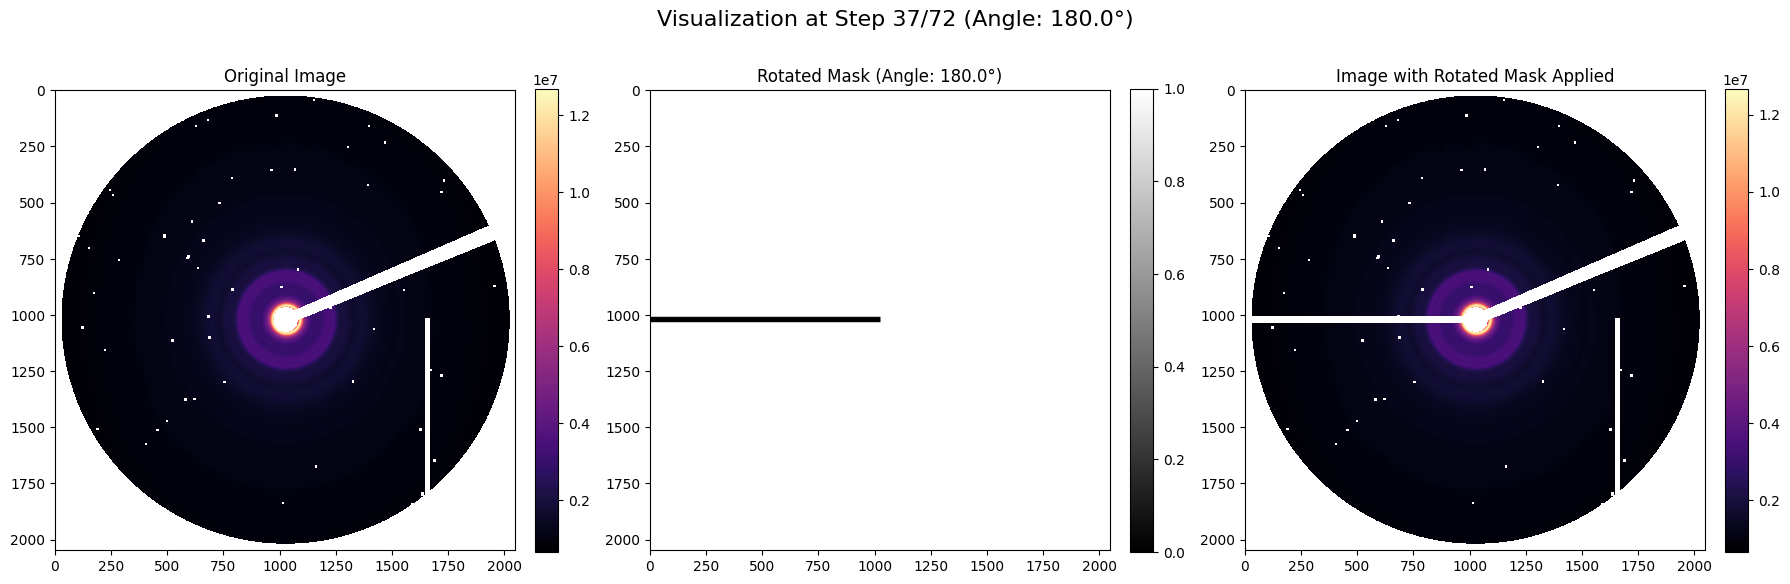


Processing angle 38/72: 185.000 degrees

Processing angle 39/72: 190.000 degrees

Processing angle 40/72: 195.000 degrees

Processing angle 41/72: 200.000 degrees


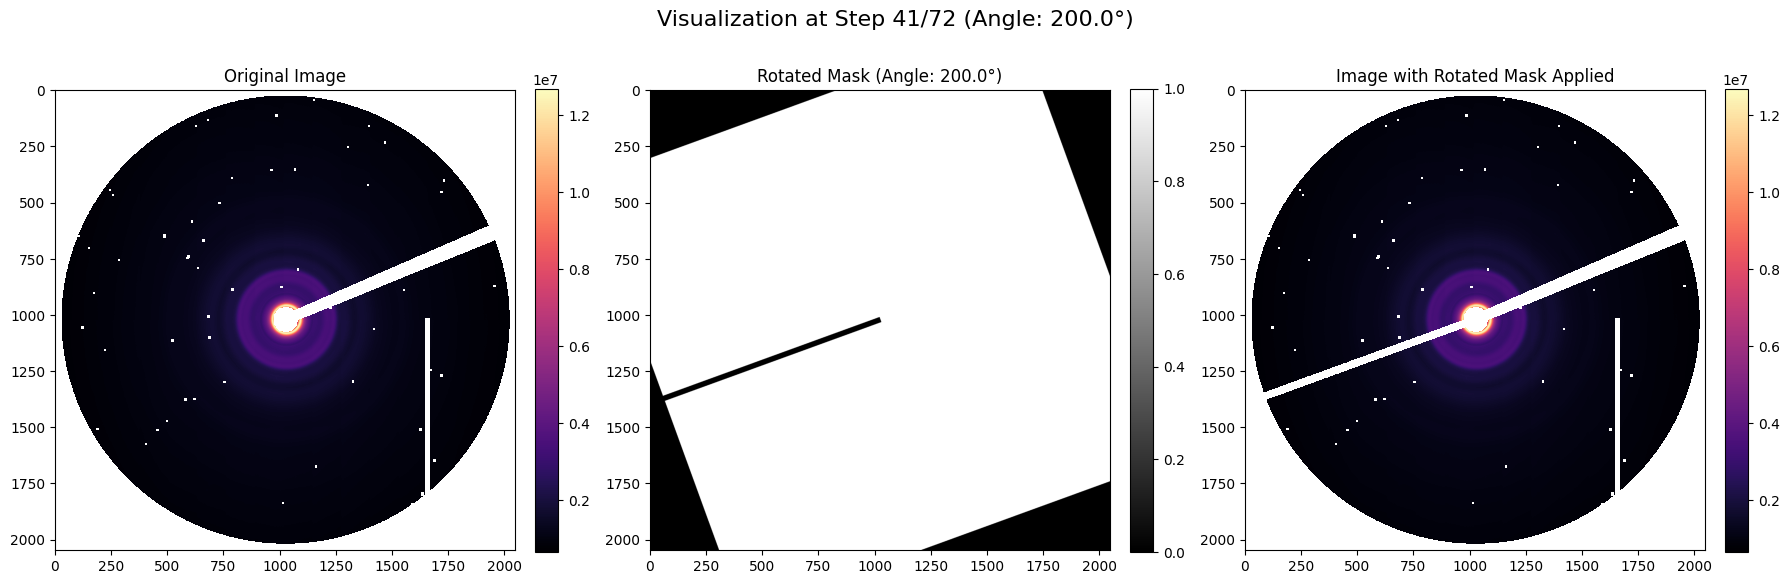


Processing angle 42/72: 205.000 degrees
Completed 42/72 integrations (58.3%)

Processing angle 43/72: 210.000 degrees

Processing angle 44/72: 215.000 degrees

Processing angle 45/72: 220.000 degrees


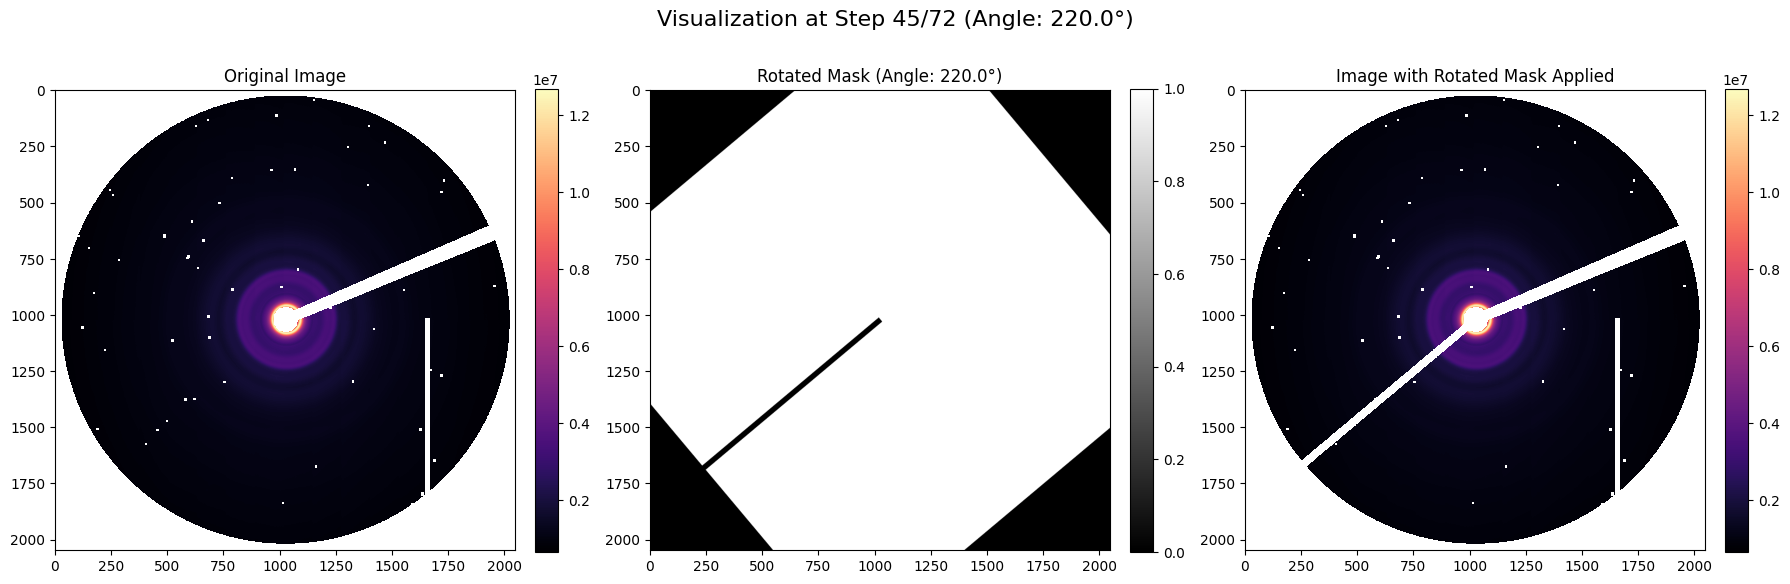


Processing angle 46/72: 225.000 degrees

Processing angle 47/72: 230.000 degrees

Processing angle 48/72: 235.000 degrees

Processing angle 49/72: 240.000 degrees


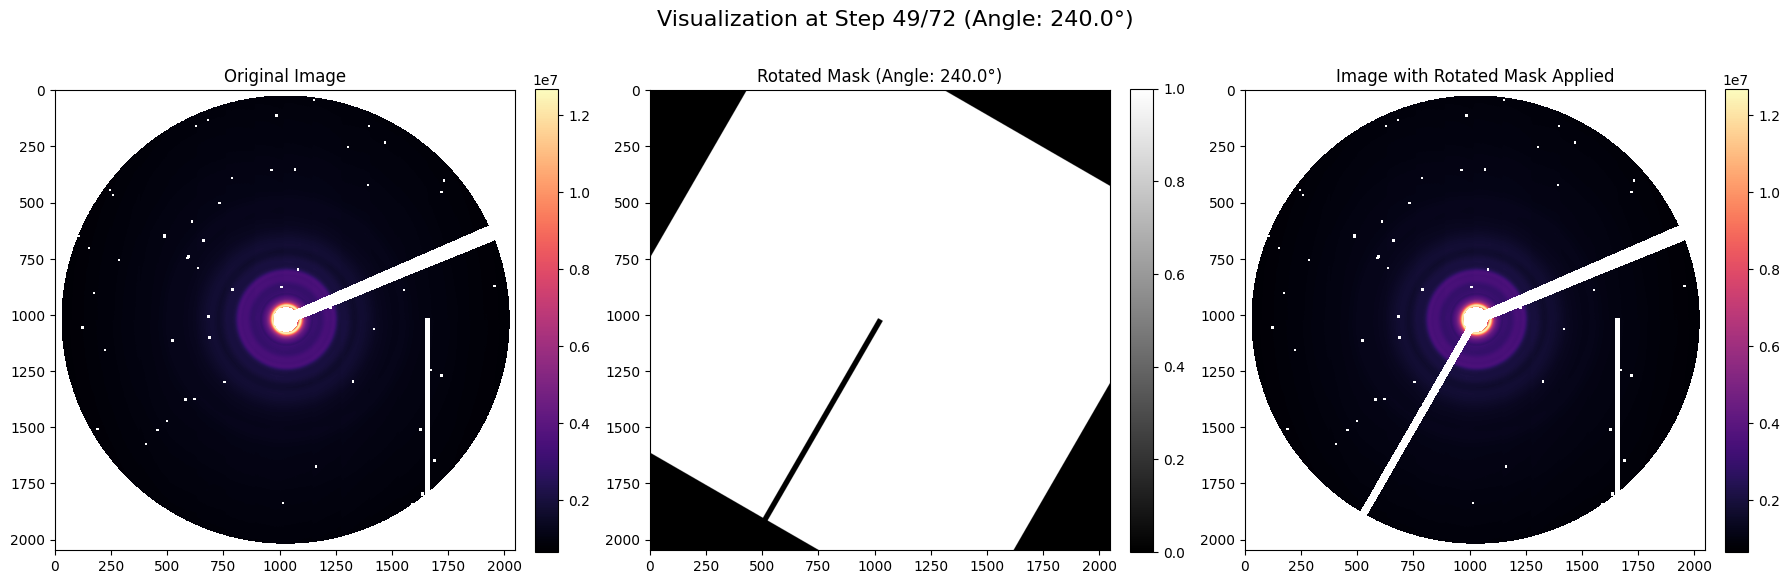

Completed 49/72 integrations (68.1%)

Processing angle 50/72: 245.000 degrees

Processing angle 51/72: 250.000 degrees

Processing angle 52/72: 255.000 degrees

Processing angle 53/72: 260.000 degrees


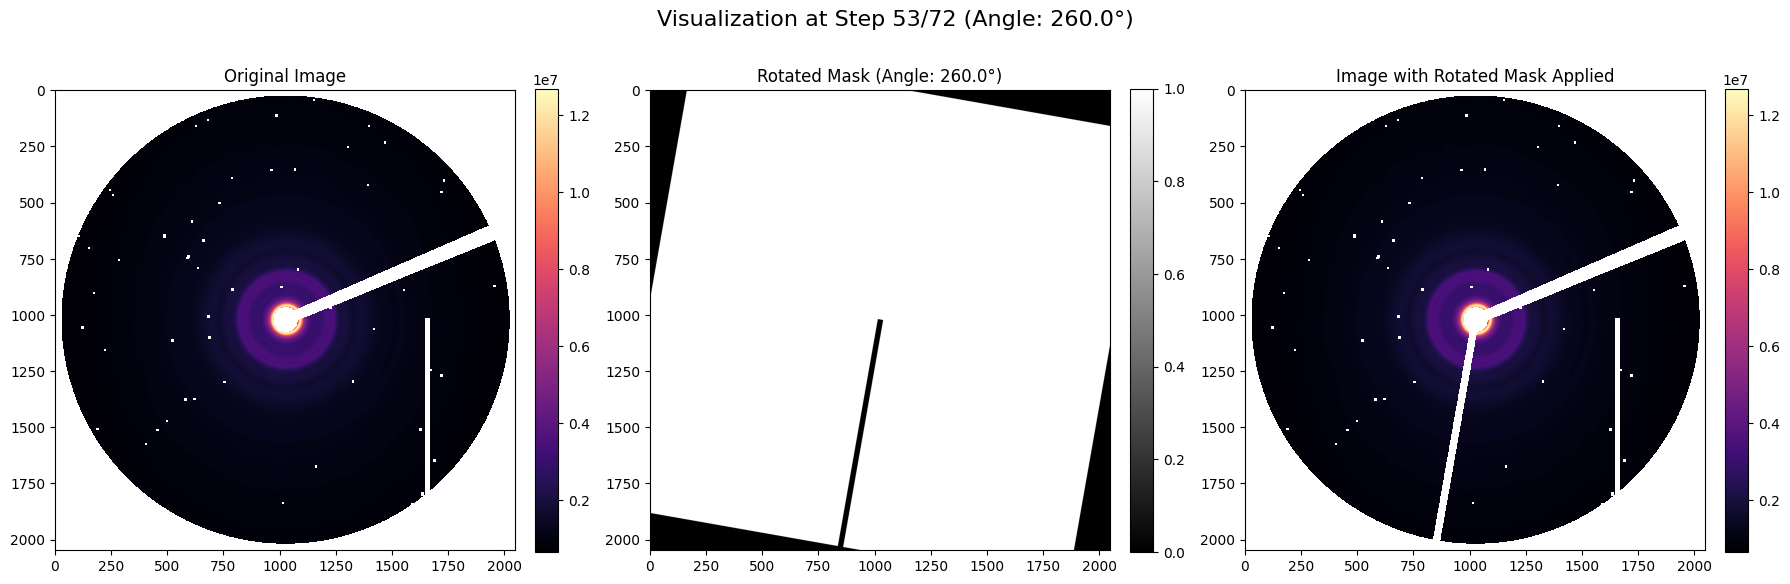


Processing angle 54/72: 265.000 degrees

Processing angle 55/72: 270.000 degrees

Processing angle 56/72: 275.000 degrees
Completed 56/72 integrations (77.8%)

Processing angle 57/72: 280.000 degrees


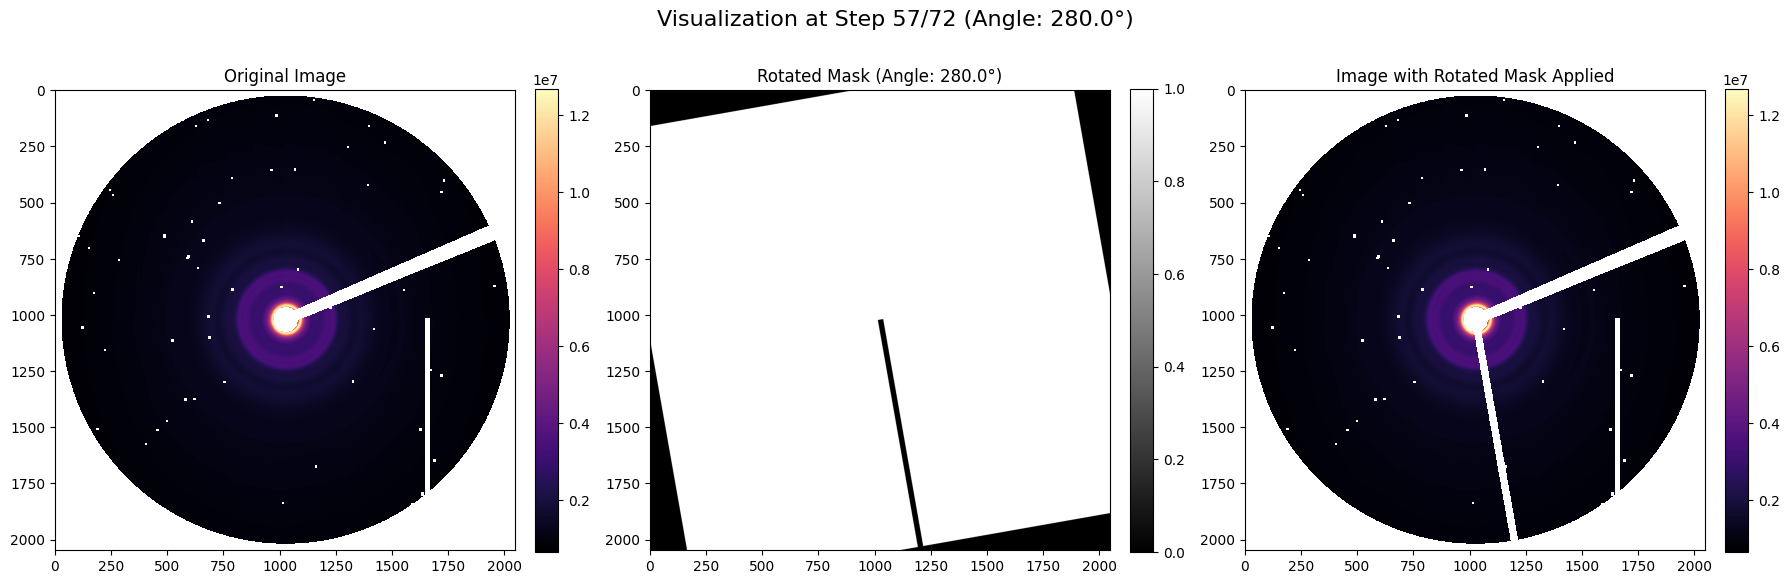


Processing angle 58/72: 285.000 degrees

Processing angle 59/72: 290.000 degrees

Processing angle 60/72: 295.000 degrees

Processing angle 61/72: 300.000 degrees


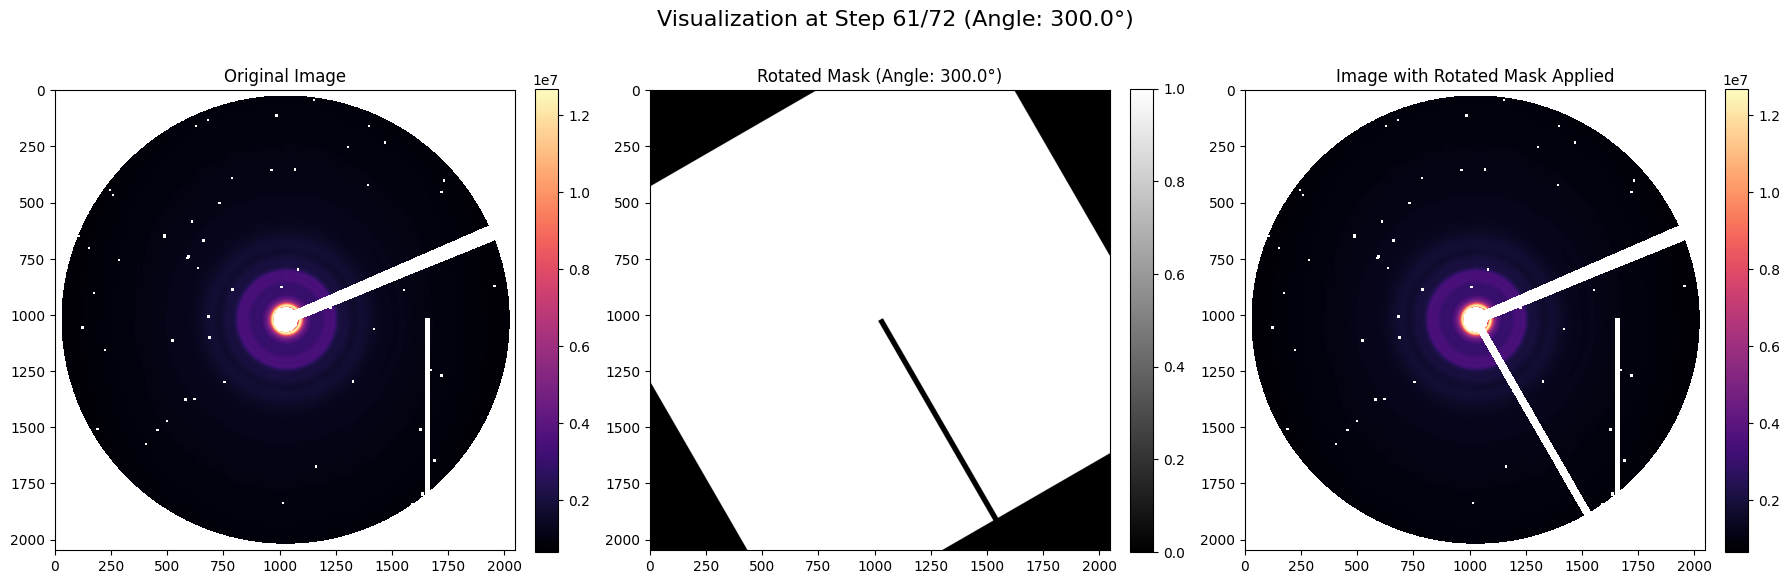


Processing angle 62/72: 305.000 degrees

Processing angle 63/72: 310.000 degrees
Completed 63/72 integrations (87.5%)

Processing angle 64/72: 315.000 degrees

Processing angle 65/72: 320.000 degrees


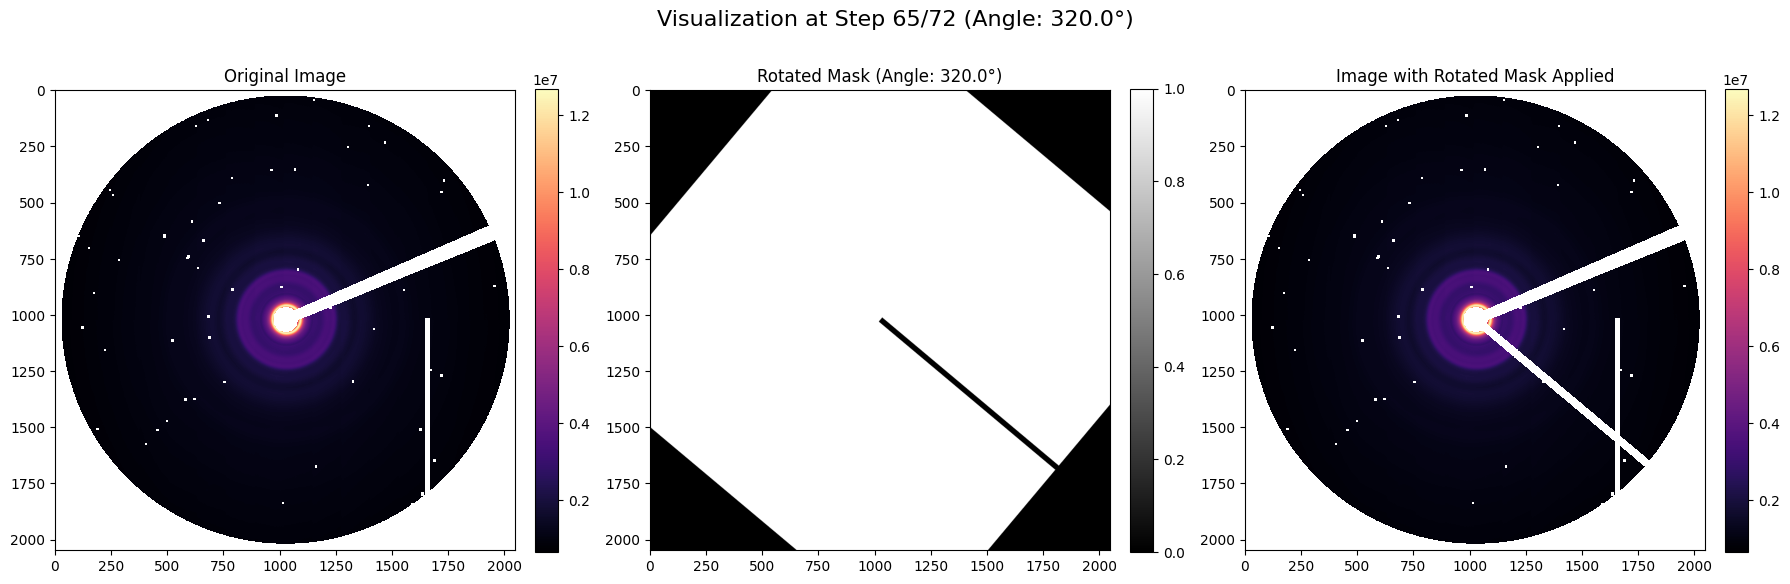


Processing angle 66/72: 325.000 degrees

Processing angle 67/72: 330.000 degrees

Processing angle 68/72: 335.000 degrees

Processing angle 69/72: 340.000 degrees


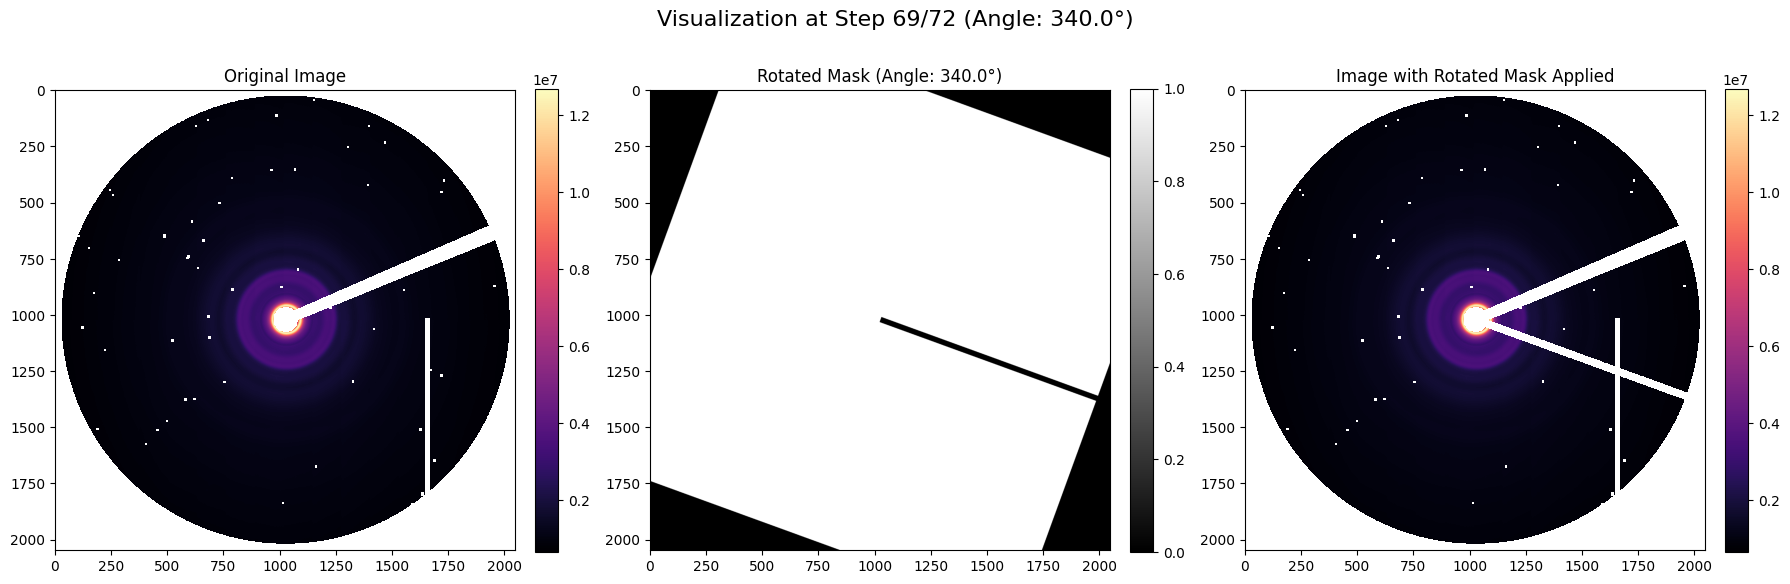


Processing angle 70/72: 345.000 degrees
Completed 70/72 integrations (97.2%)

Processing angle 71/72: 350.000 degrees

Processing angle 72/72: 355.000 degrees


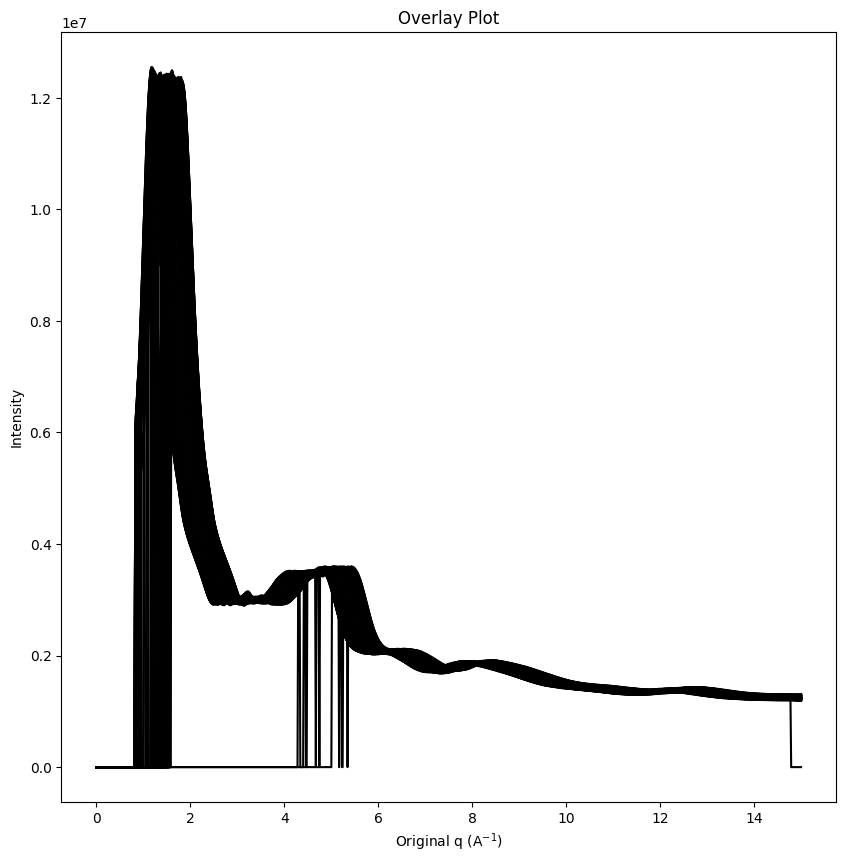

In [29]:
q, cryst_C_GST_SiO2_TM = rotate_and_integrate_maskdebug(tm_circle, 5, .41794313, 1.22224e-11, resolution = 1000, mask = mask_12)

In [35]:
def rotate_and_integrate_maskdebug2(combined_image, angle_of_rotation, distance, wavelength, resolution=3000, mask=None, 
                         intermediate_steps=18): 
    """
    This function takes the combined image, the mask, the distance, the wavelength, and the resolution of integration, 
    and rotates the mask by a user specified angle amount, if the angle specified is 1, 
    the result will be 360 integrations of the combined image with different mask orientations.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        distance (float): The distance from the detector to the sample.
        wavelength (float): The wavelength of the x-rays.
        resolution (int): The resolution of the integration.
        mask (2D array): The mask to use for the integration.
        visualization_steps (int): How many intermediate visualizations to show (will plot every n steps)
    """
    
    import pandas as pd 
    
    print(f"Starting rotate_and_integrate function")
    
    #create a dataframe to store the 1D integrations
    df = pd.DataFrame()

    # Calculate number of steps for 360 degrees
    n_steps = int(360 / angle_of_rotation)
    angles = np.linspace(0, 360, n_steps, endpoint=False)
    
    # Determine how often to show visualizations
    visualization_interval = max(1, n_steps // intermediate_steps)
    print(f"Will show visualizations every {visualization_interval} steps")

    # Pre-allocate lists to store data
    intensity_data = []
    angle_labels = []

    # Get image center
    center_y, center_x = combined_image.shape[0] // 2, combined_image.shape[1] // 2

    # Create a loop that rotates the mask
    for i, angle in enumerate(angles):
        print(f"\nProcessing angle {i+1}/{n_steps}: {angle:.3f} degrees")
        
        # Rotate the mask instead of the image
        if mask is not None:
            rotated_mask = image_rotation(mask, angle)
                    # Make sure mask is binary (0 or 1)
            if rotated_mask.dtype != bool:
                binary_mask = rotated_mask.astype(bool).astype(int)
            else:
                binary_mask = rotated_mask.astype(int)
        else:
            rotated_mask = None
            binary_mask = None
        
        # Show intermediate visualizations at regular intervals
        if i % visualization_interval == 0:
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # Plot the original image
            im0 = axes[0].imshow(combined_image, cmap='magma')
            axes[0].set_title(f"Original Image")
            plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
            
            # Plot the rotated mask - with clearer representation
            if binary_mask is not None:
                # Invert the mask for display (1 is masked, 0 is data for pyFAI)
                display_mask = 1 - binary_mask
                im1 = axes[1].imshow(display_mask, cmap='gray')
                axes[1].set_title(f"Rotated Mask (Angle: {angle:.1f}°)\nWhite = Masked, Black = Used")
                plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
            else:
                axes[1].text(0.5, 0.5, "No Mask", ha='center', va='center')
                axes[1].set_title("No Mask Provided")
            
            # Plot what will actually be integrated
            if binary_mask is not None:
                # Create a masked array to show what will be integrated
                # In pyFAI, pixels where mask=0 are integrated, mask=1 are ignored
                masked_data = np.ma.masked_array(combined_image, mask=binary_mask)
                
                im2 = axes[2].imshow(masked_data, cmap='magma')
                axes[2].set_title("What Will Be Integrated\n(Color = Used, Masked = Hidden)")
                
                # Add gridlines to help visualize
                axes[2].grid(color='white', linestyle='-', linewidth=0.5, alpha=0.3)
                
                # Add center marker
                axes[2].plot(center_x, center_y, 'rx', markersize=10)
            else:
                im2 = axes[2].imshow(combined_image, cmap='magma')
                axes[2].set_title("Full Image (No Mask)")
                axes[2].plot(center_x, center_y, 'rx', markersize=10)
            plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
            
            plt.tight_layout()
            plt.suptitle(f"Visualization at Step {i+1}/{n_steps} (Angle: {angle:.1f}°)", fontsize=16)
            plt.subplots_adjust(top=0.9)
            plt.show()
        
        # Integrate the image with the rotated mask
        q, I = integrate_image(combined_image, distance, wavelength, resolution, mask=rotated_mask, show=False)
        
        # Store data
        intensity_data.append(I)
        angle_labels.append(f"{angle:.3f}")
        
        # Print progress every 10% of steps
        progress_interval = max(1, n_steps // 10)
        if (i+1) % progress_interval == 0:
            print(f"Completed {i+1}/{n_steps} integrations ({(i+1)/n_steps*100:.1f}%)")
    
    # Create DataFrame all at once
    df = pd.DataFrame(np.array(intensity_data).T, columns=angle_labels)
    
    # Create a waterfall plot of the 1D integrations
    plt.figure(figsize=(10, 10))
    for angle in angles[1:len(angles)-1]:  # Skip first & last angles
        plt.plot(q, (df[f"{angle:.3f}"]), c='black')
    plt.xlabel('Original q (A$^{-1}$)')
    plt.ylabel('Intensity')
    plt.title("Overlay Plot")
    plt.show()     
    return q, df

Starting rotate_and_integrate function
Will show visualizations every 4 steps

Processing angle 1/72: 0.000 degrees


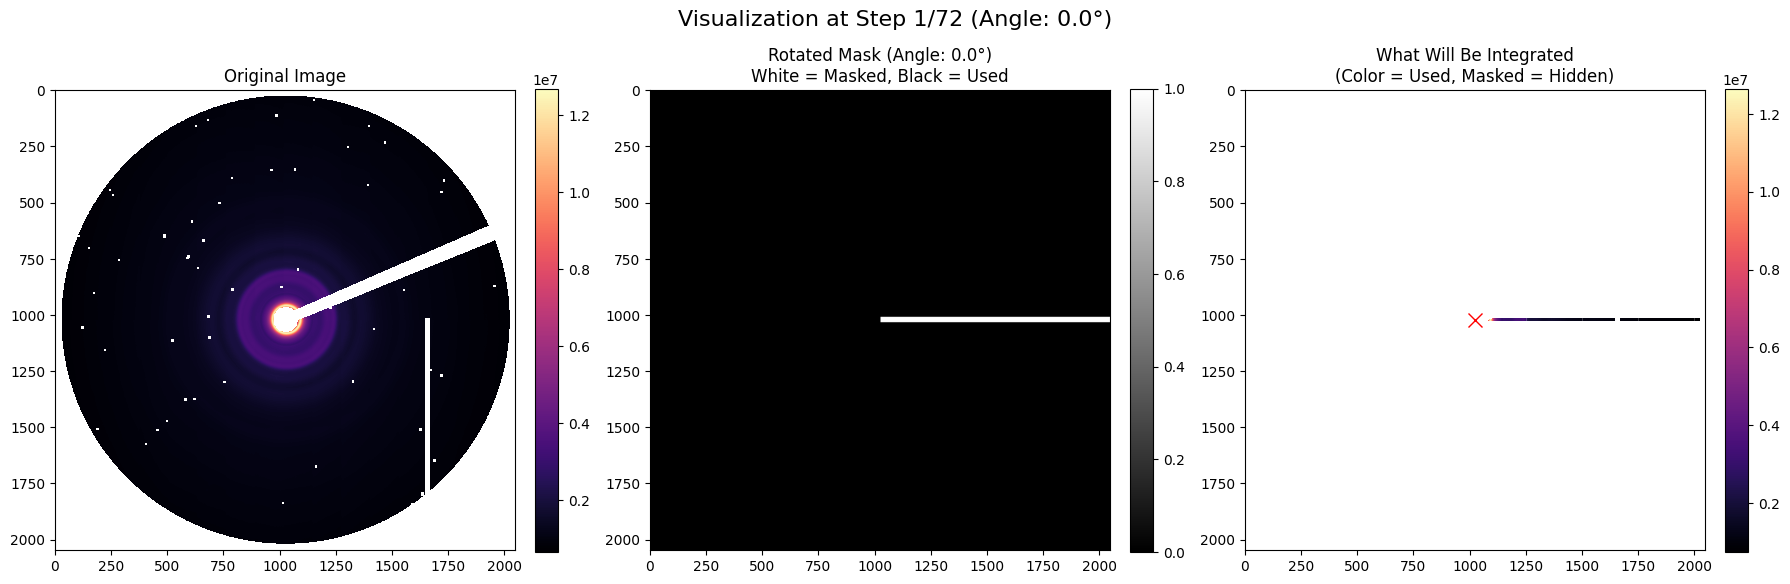


Processing angle 2/72: 5.000 degrees

Processing angle 3/72: 10.000 degrees

Processing angle 4/72: 15.000 degrees

Processing angle 5/72: 20.000 degrees


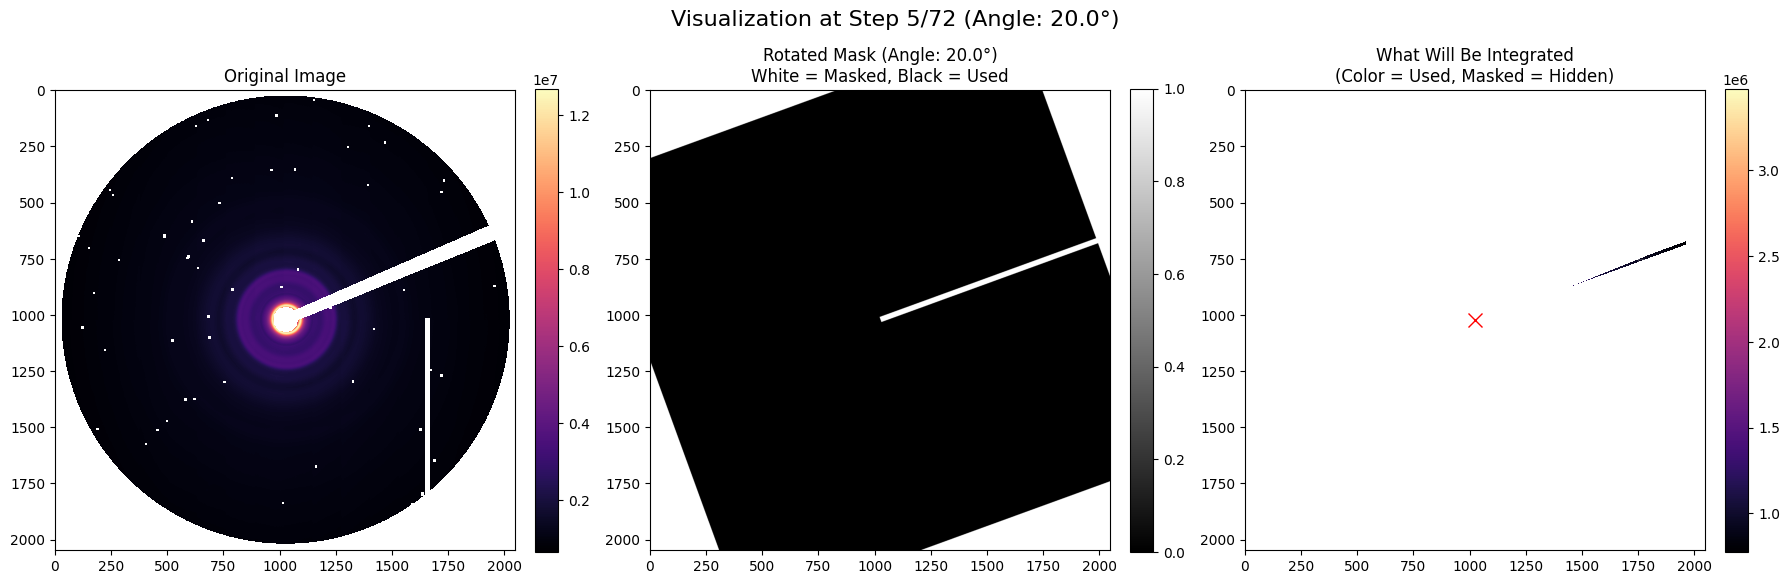


Processing angle 6/72: 25.000 degrees

Processing angle 7/72: 30.000 degrees
Completed 7/72 integrations (9.7%)

Processing angle 8/72: 35.000 degrees

Processing angle 9/72: 40.000 degrees


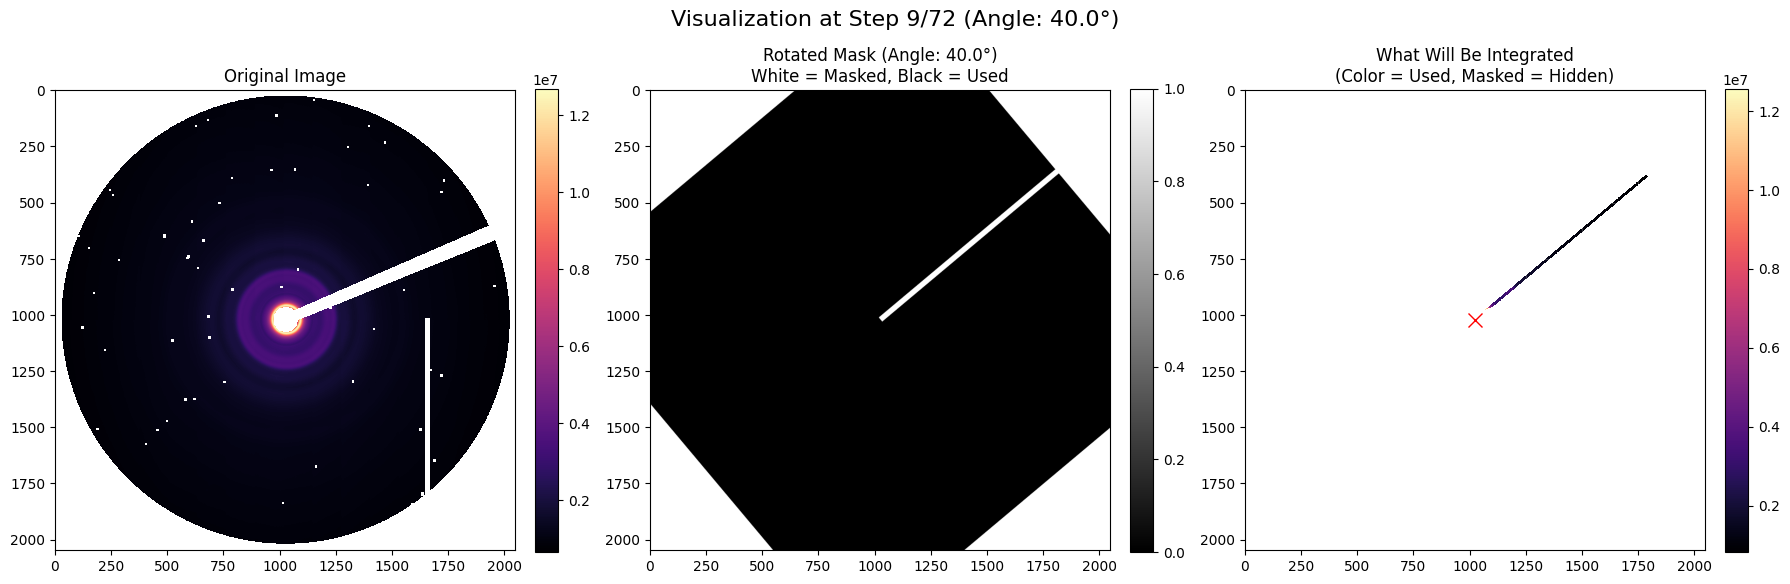


Processing angle 10/72: 45.000 degrees

Processing angle 11/72: 50.000 degrees

Processing angle 12/72: 55.000 degrees

Processing angle 13/72: 60.000 degrees


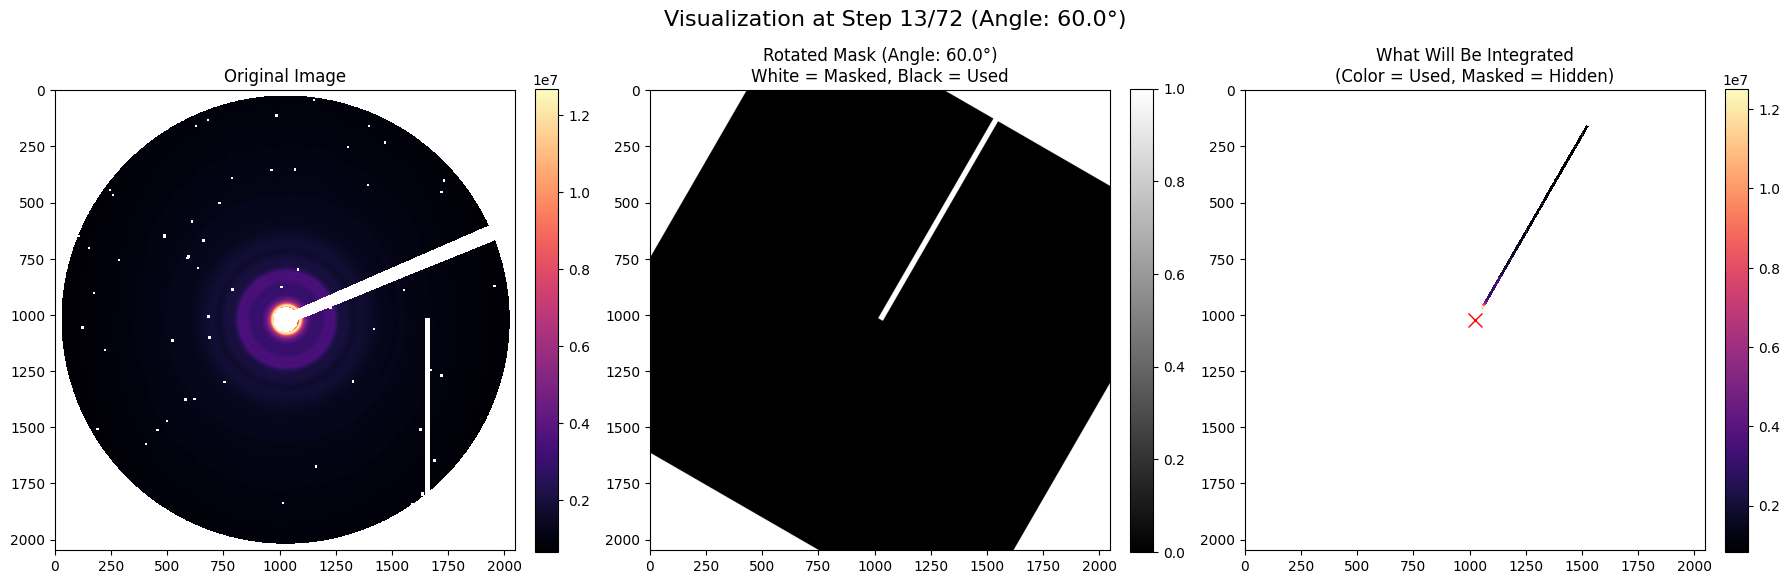


Processing angle 14/72: 65.000 degrees
Completed 14/72 integrations (19.4%)

Processing angle 15/72: 70.000 degrees

Processing angle 16/72: 75.000 degrees

Processing angle 17/72: 80.000 degrees


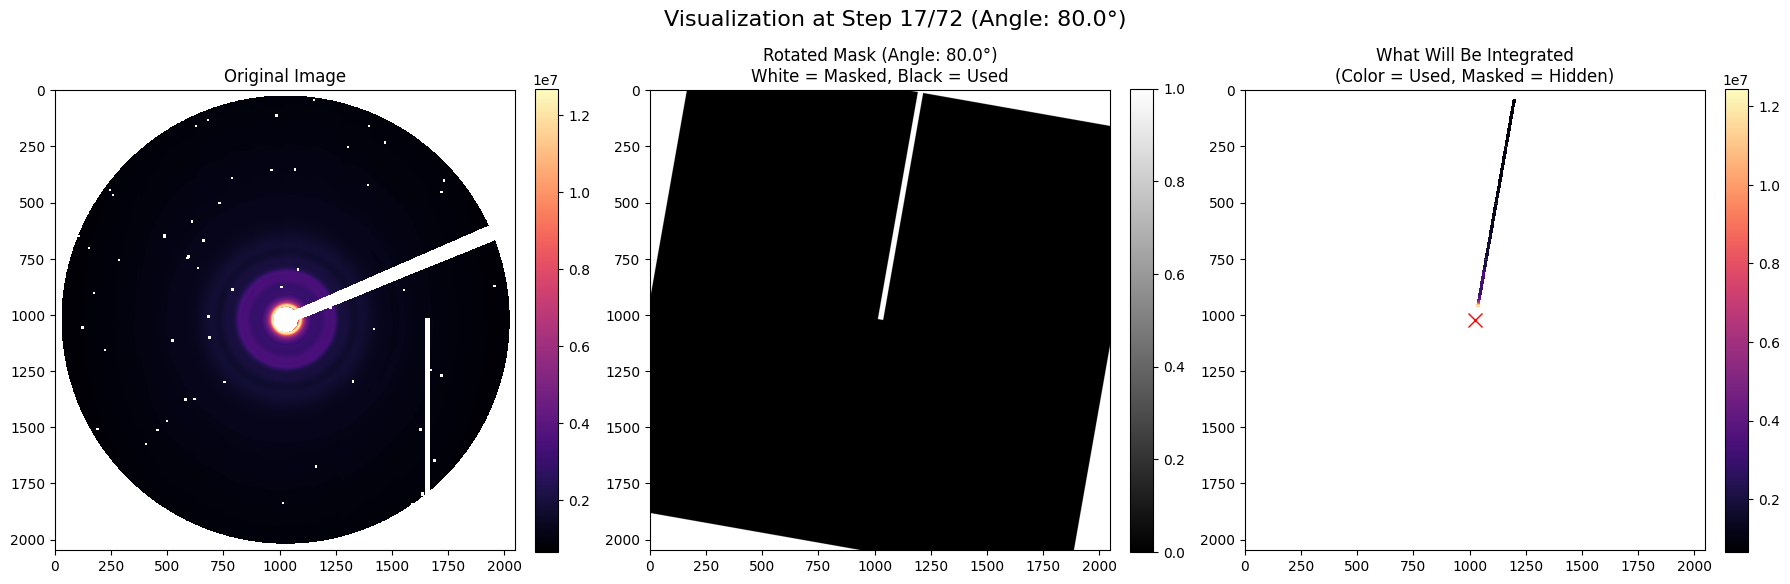


Processing angle 18/72: 85.000 degrees

Processing angle 19/72: 90.000 degrees

Processing angle 20/72: 95.000 degrees

Processing angle 21/72: 100.000 degrees


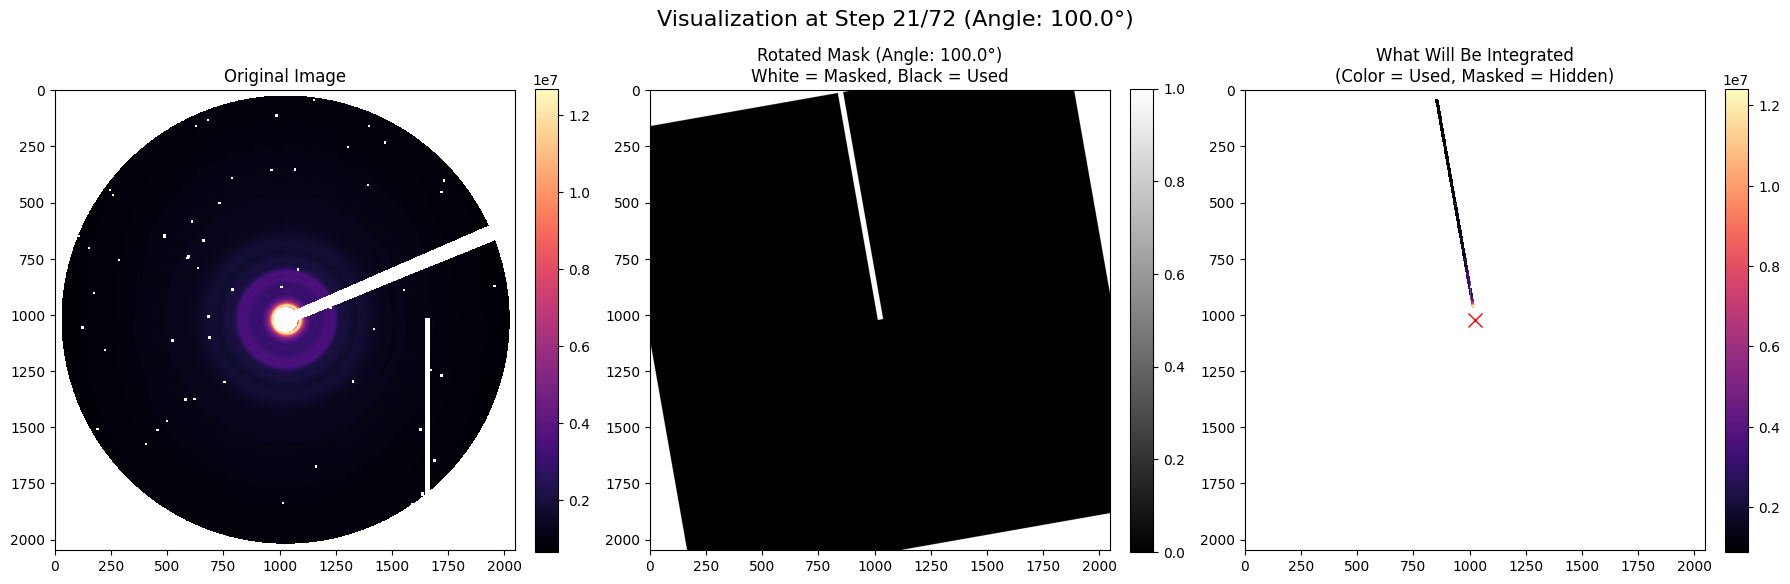

Completed 21/72 integrations (29.2%)

Processing angle 22/72: 105.000 degrees

Processing angle 23/72: 110.000 degrees

Processing angle 24/72: 115.000 degrees

Processing angle 25/72: 120.000 degrees


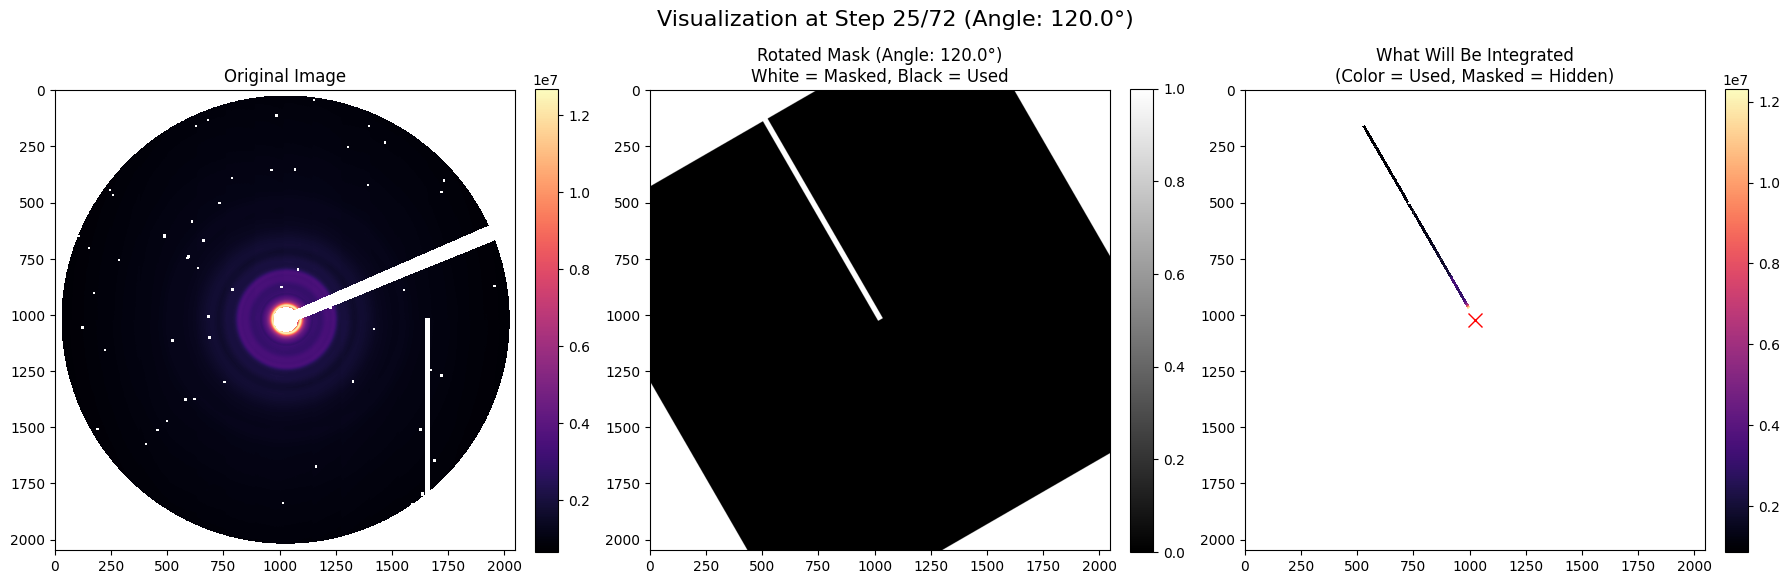


Processing angle 26/72: 125.000 degrees

Processing angle 27/72: 130.000 degrees

Processing angle 28/72: 135.000 degrees
Completed 28/72 integrations (38.9%)

Processing angle 29/72: 140.000 degrees


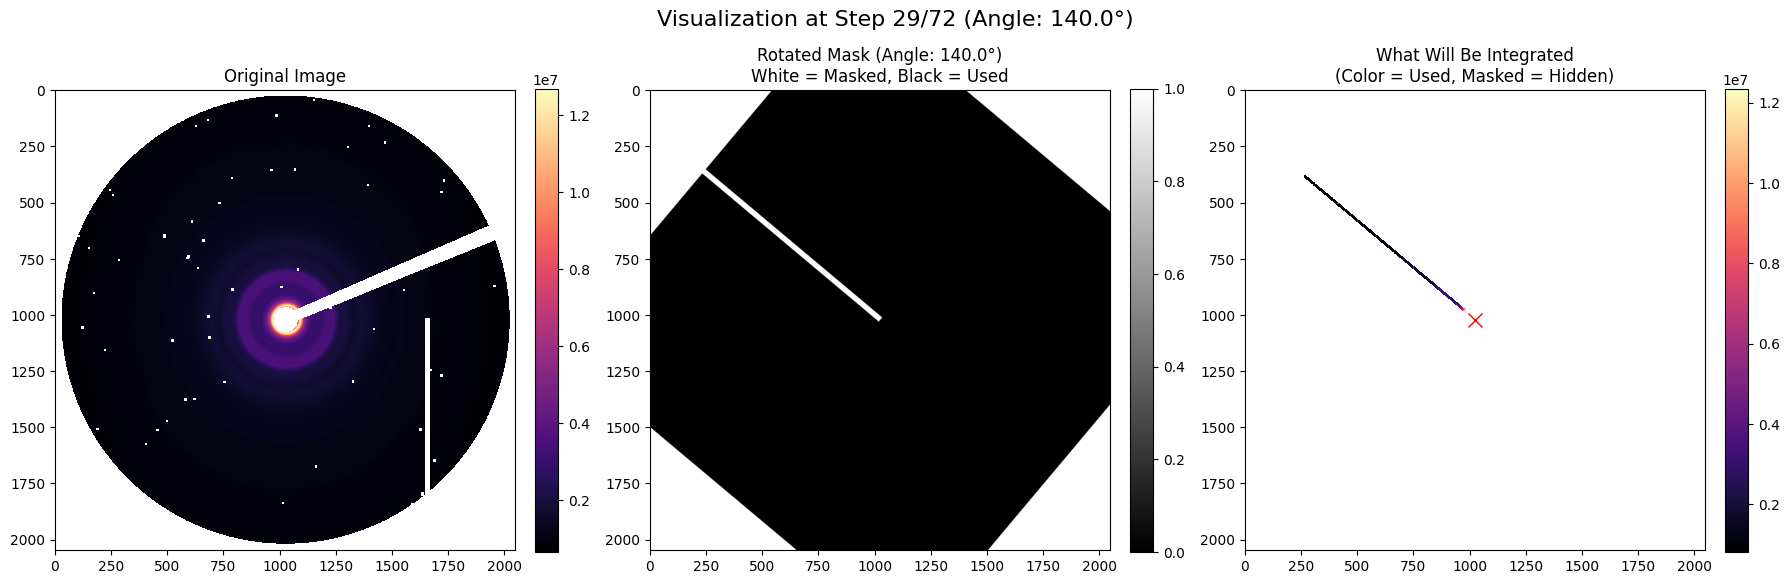


Processing angle 30/72: 145.000 degrees

Processing angle 31/72: 150.000 degrees

Processing angle 32/72: 155.000 degrees

Processing angle 33/72: 160.000 degrees


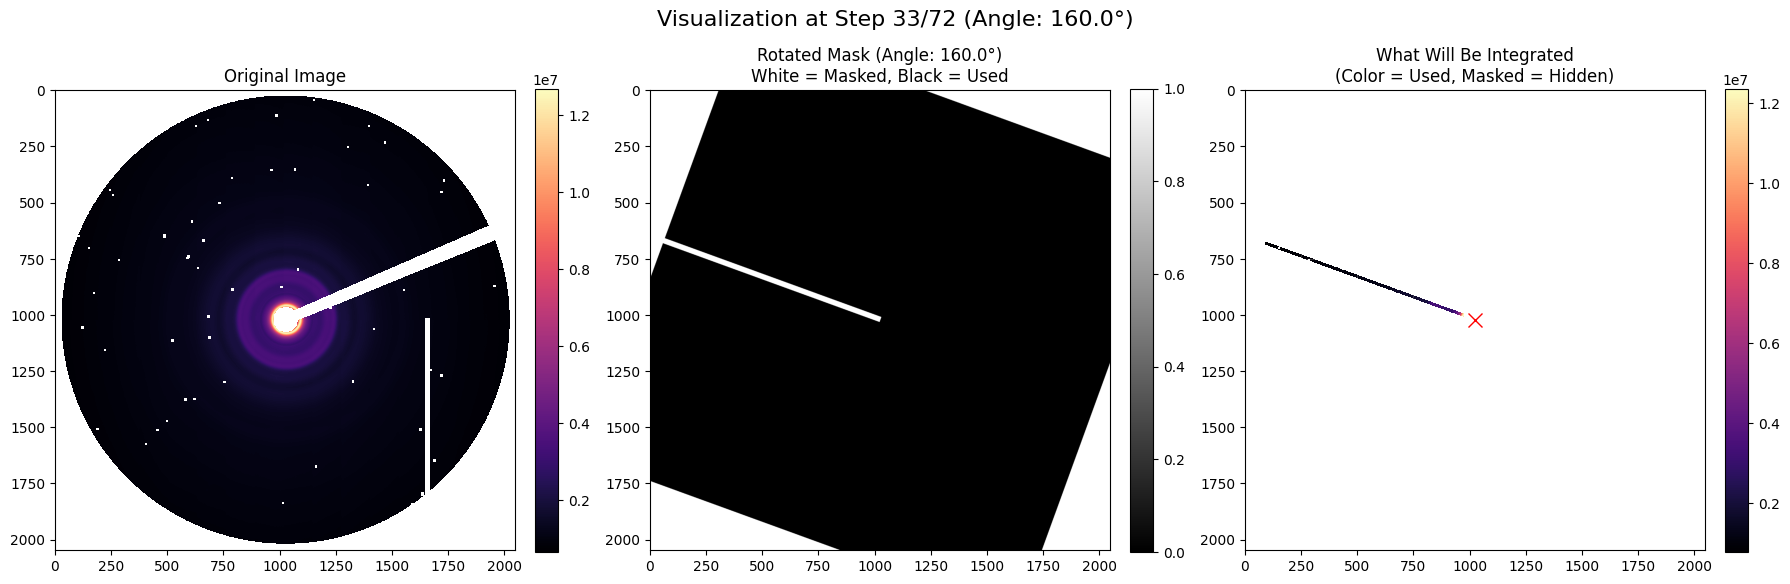


Processing angle 34/72: 165.000 degrees

Processing angle 35/72: 170.000 degrees
Completed 35/72 integrations (48.6%)

Processing angle 36/72: 175.000 degrees

Processing angle 37/72: 180.000 degrees


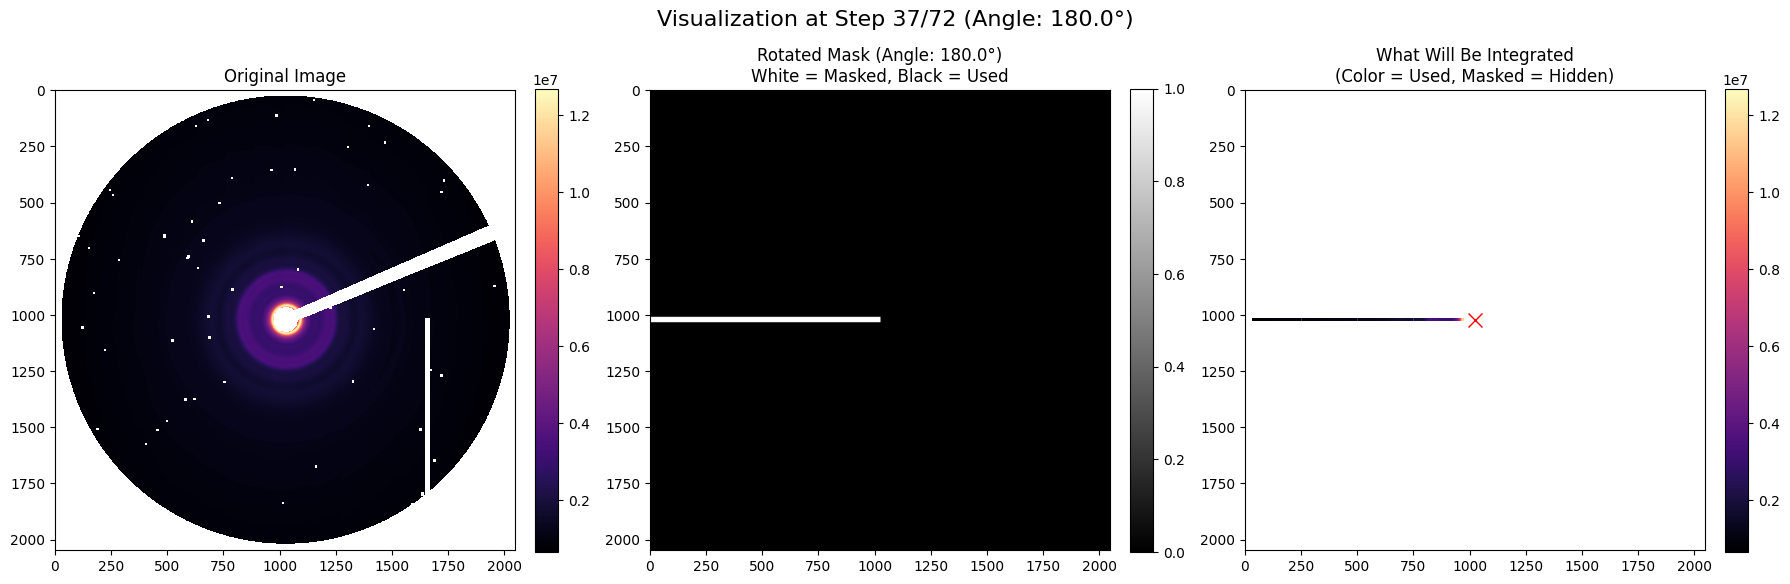


Processing angle 38/72: 185.000 degrees

Processing angle 39/72: 190.000 degrees

Processing angle 40/72: 195.000 degrees

Processing angle 41/72: 200.000 degrees


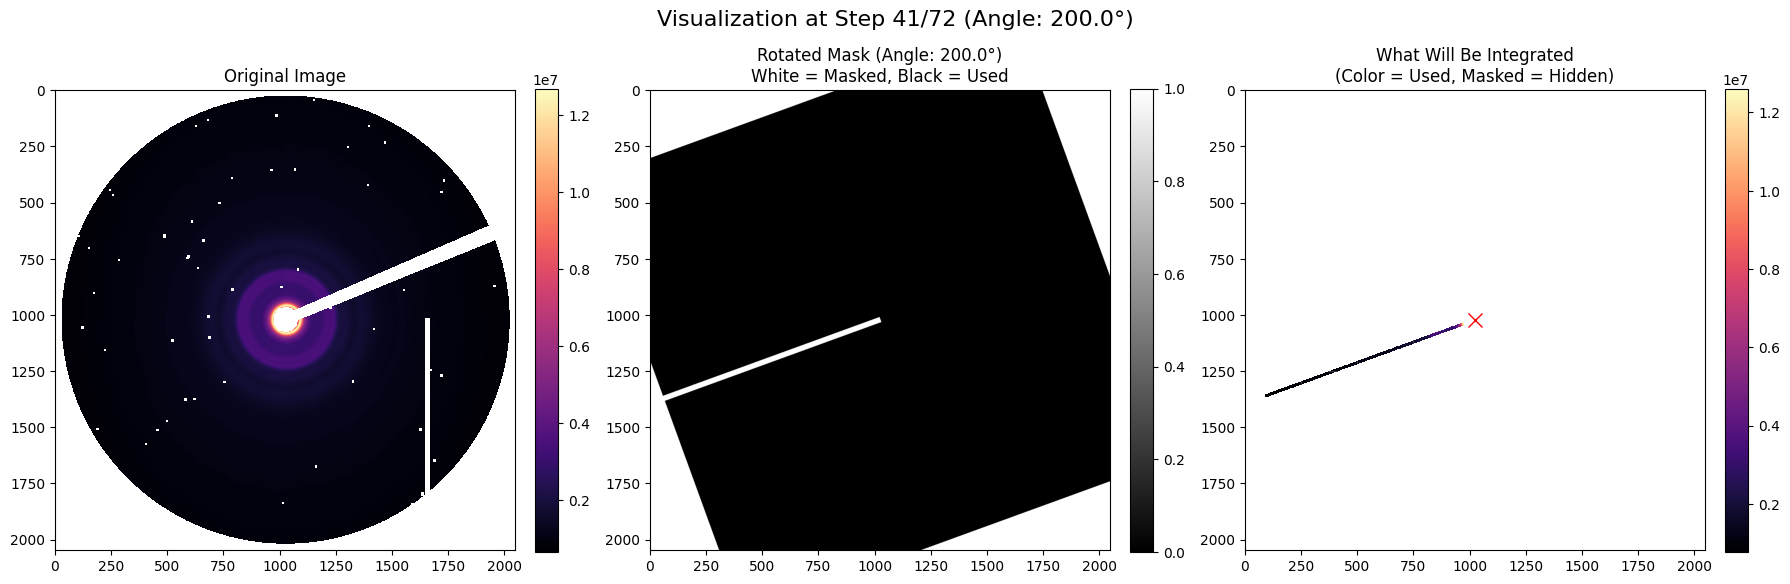


Processing angle 42/72: 205.000 degrees
Completed 42/72 integrations (58.3%)

Processing angle 43/72: 210.000 degrees

Processing angle 44/72: 215.000 degrees

Processing angle 45/72: 220.000 degrees


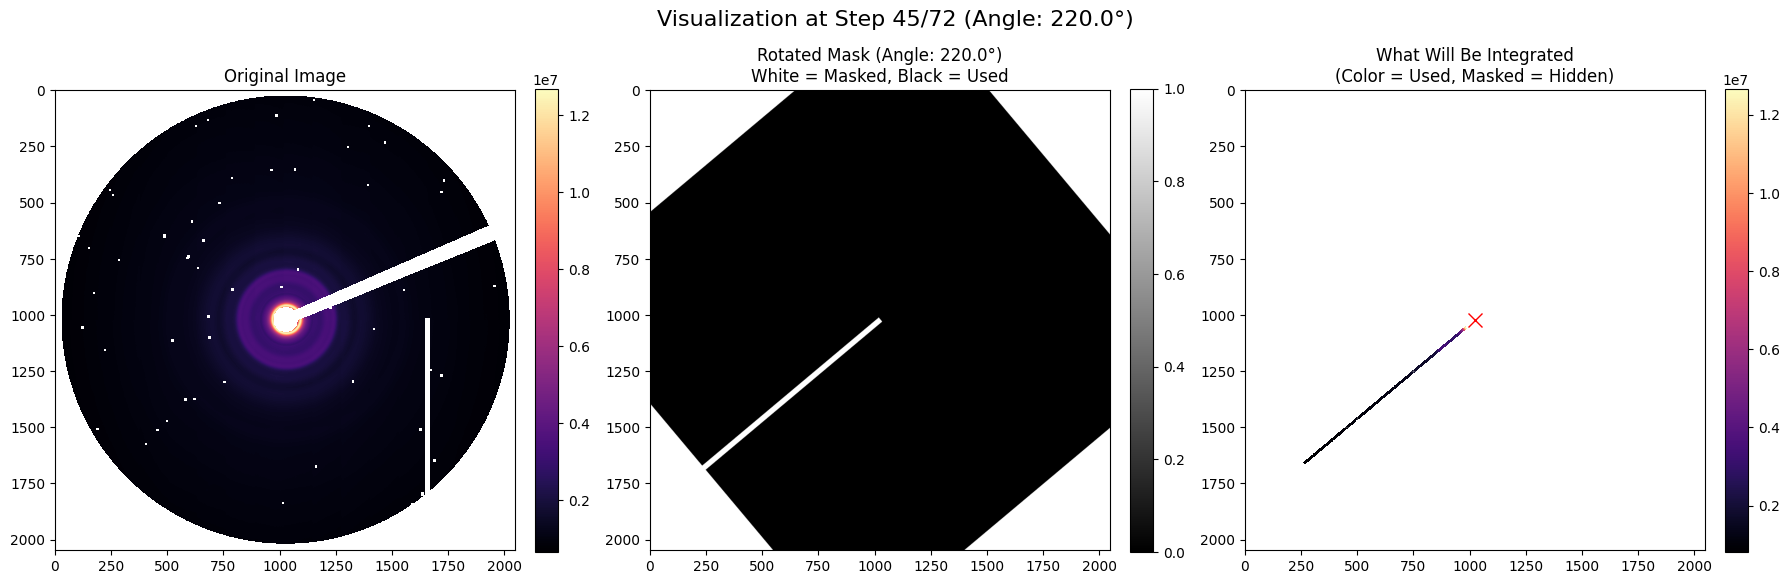


Processing angle 46/72: 225.000 degrees

Processing angle 47/72: 230.000 degrees

Processing angle 48/72: 235.000 degrees

Processing angle 49/72: 240.000 degrees


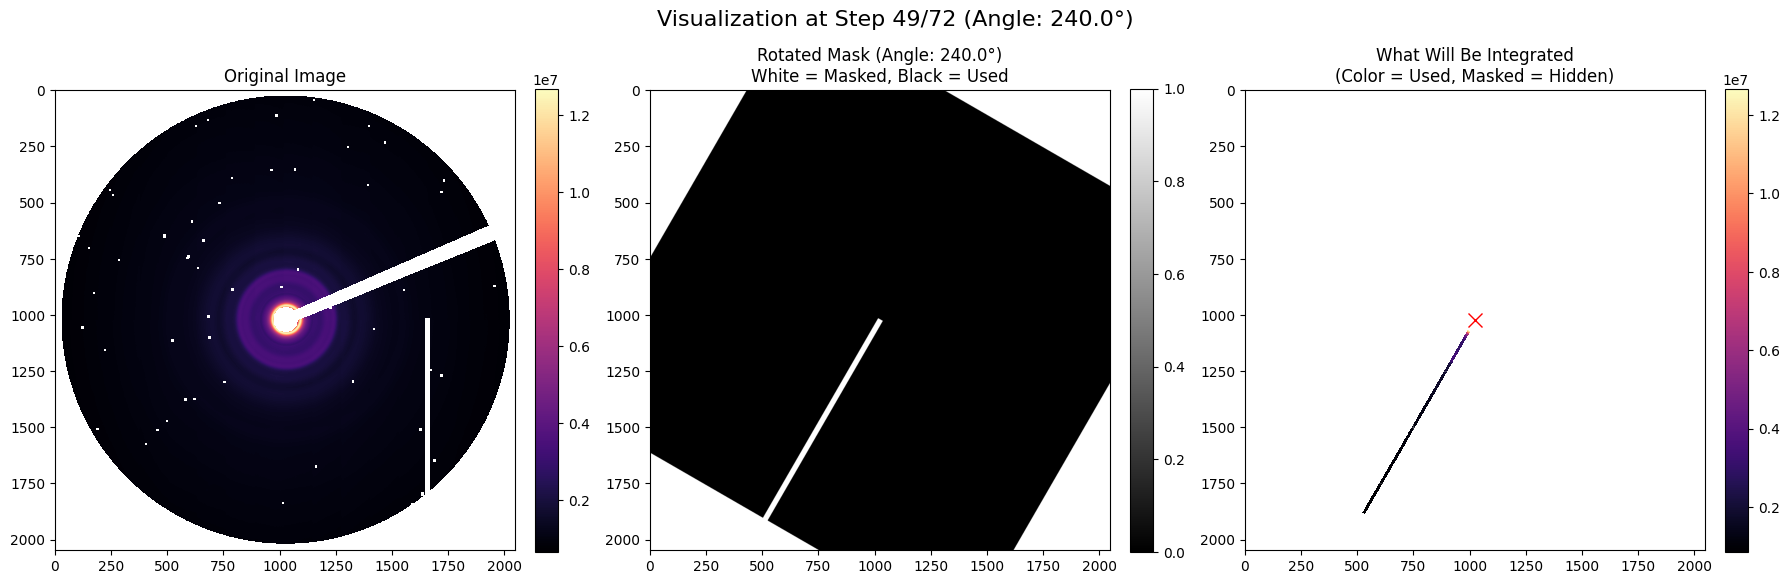

Completed 49/72 integrations (68.1%)

Processing angle 50/72: 245.000 degrees

Processing angle 51/72: 250.000 degrees

Processing angle 52/72: 255.000 degrees

Processing angle 53/72: 260.000 degrees


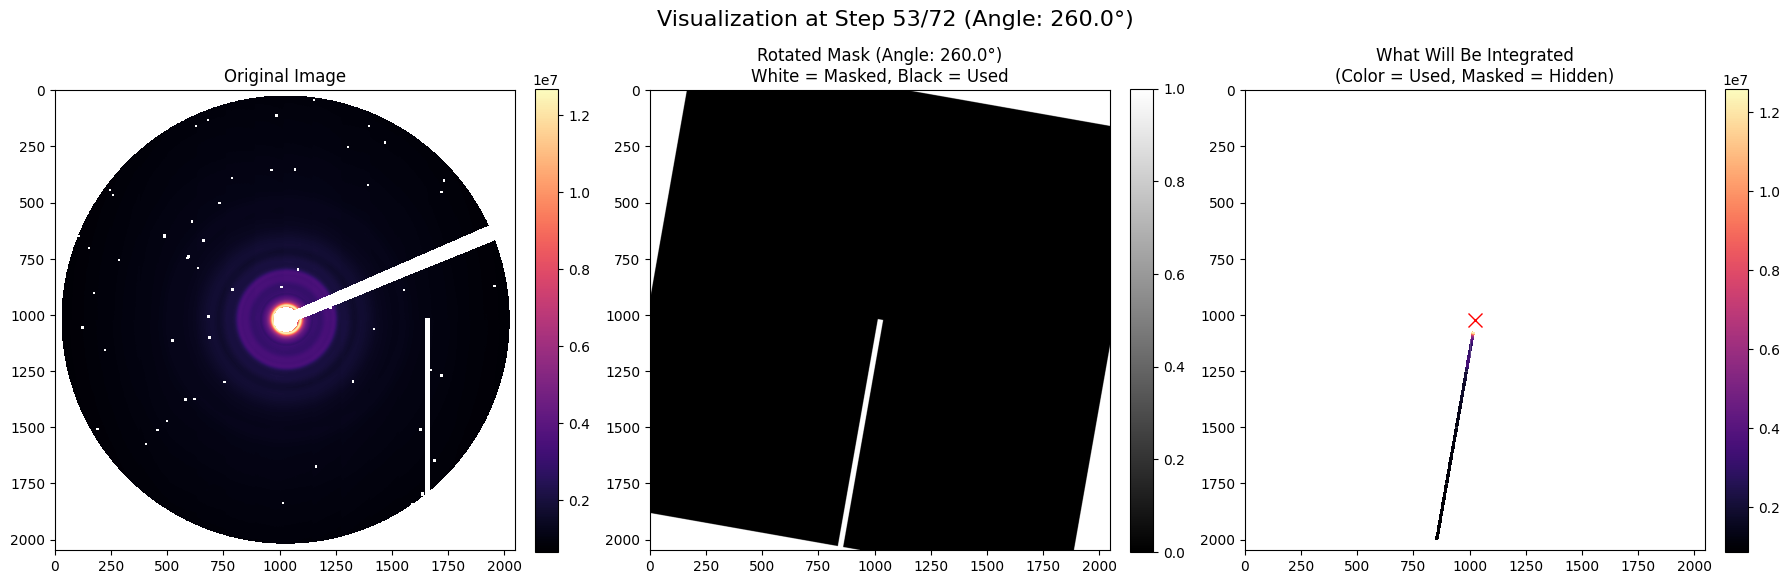


Processing angle 54/72: 265.000 degrees

Processing angle 55/72: 270.000 degrees

Processing angle 56/72: 275.000 degrees
Completed 56/72 integrations (77.8%)

Processing angle 57/72: 280.000 degrees


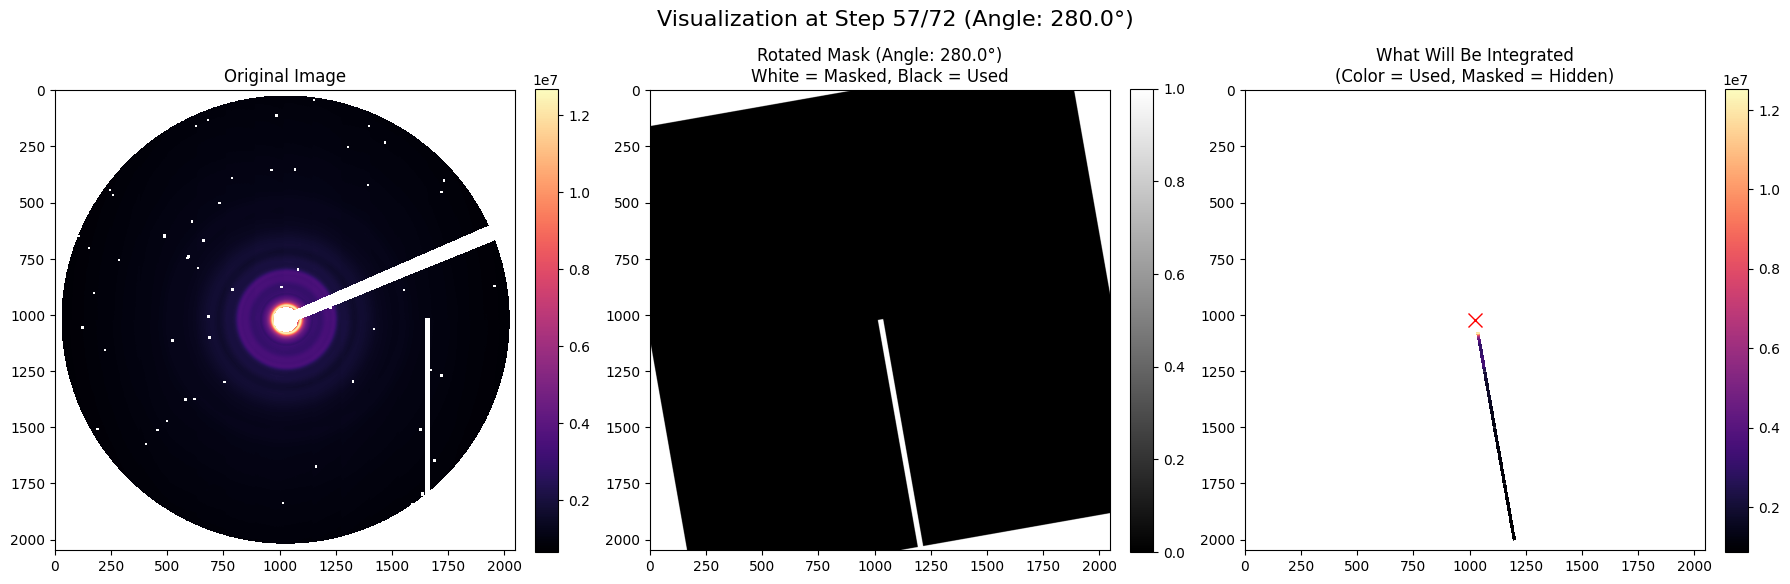


Processing angle 58/72: 285.000 degrees

Processing angle 59/72: 290.000 degrees

Processing angle 60/72: 295.000 degrees

Processing angle 61/72: 300.000 degrees


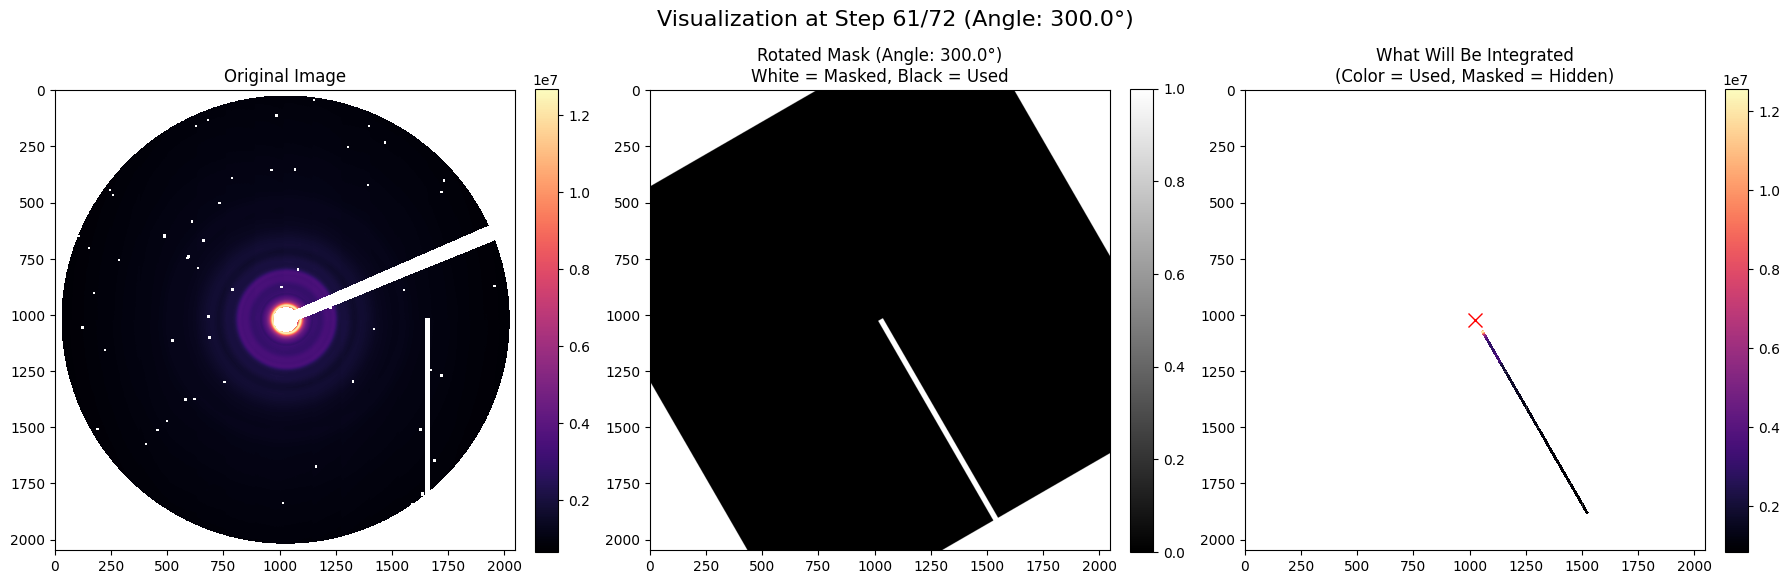


Processing angle 62/72: 305.000 degrees

Processing angle 63/72: 310.000 degrees
Completed 63/72 integrations (87.5%)

Processing angle 64/72: 315.000 degrees

Processing angle 65/72: 320.000 degrees


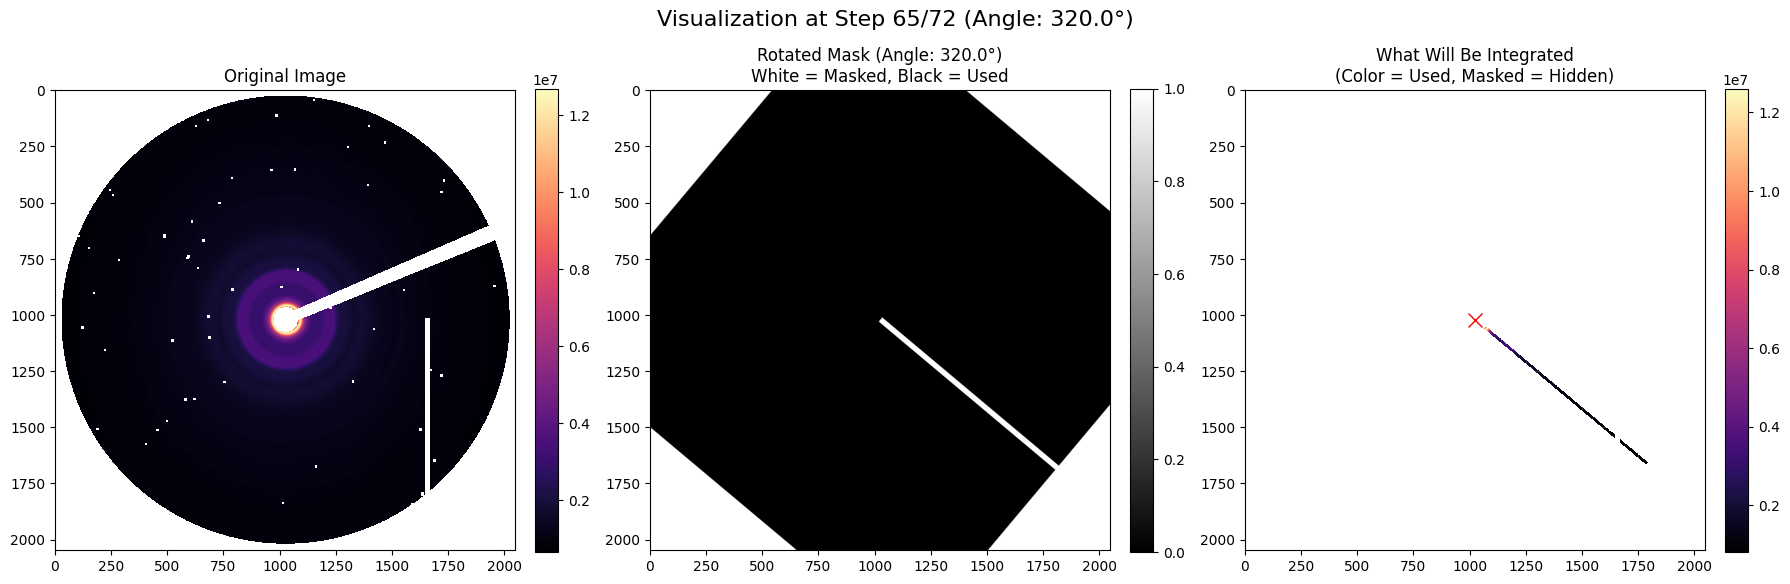


Processing angle 66/72: 325.000 degrees

Processing angle 67/72: 330.000 degrees

Processing angle 68/72: 335.000 degrees

Processing angle 69/72: 340.000 degrees


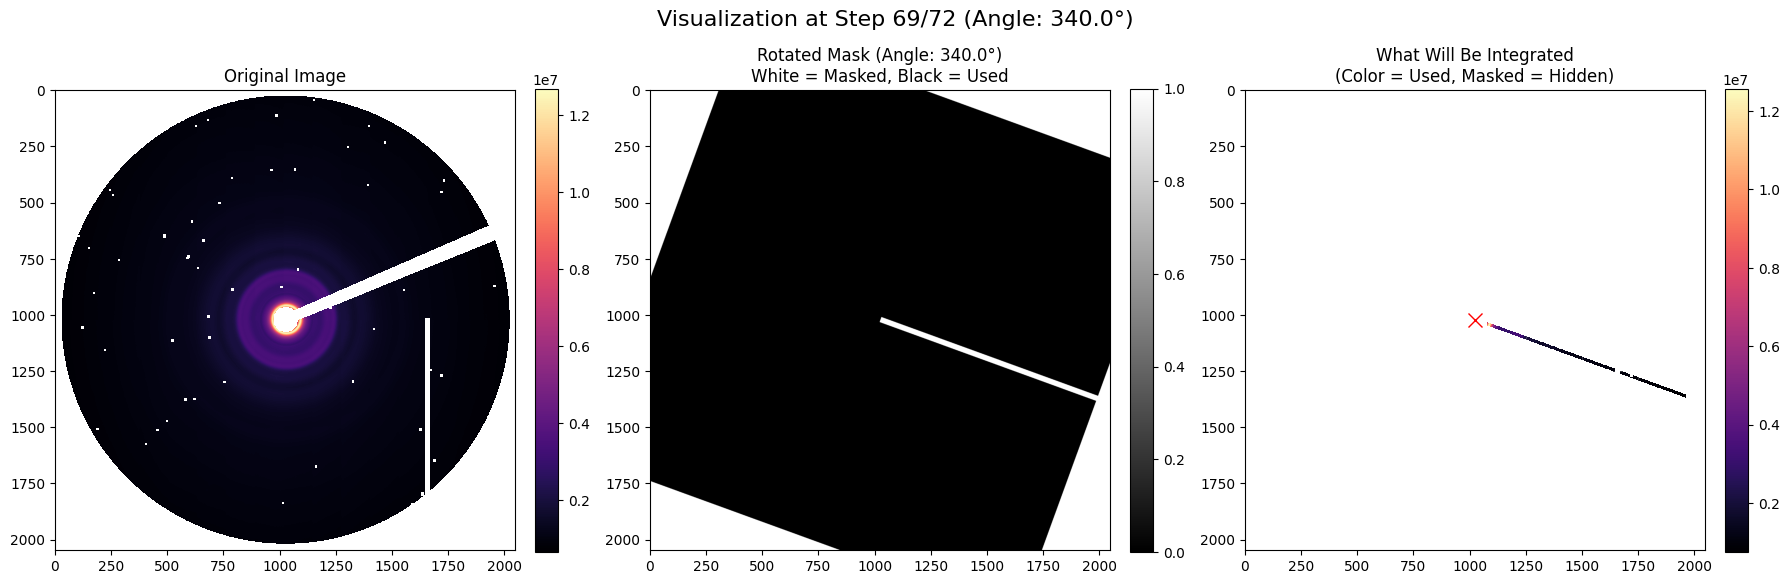


Processing angle 70/72: 345.000 degrees
Completed 70/72 integrations (97.2%)

Processing angle 71/72: 350.000 degrees

Processing angle 72/72: 355.000 degrees


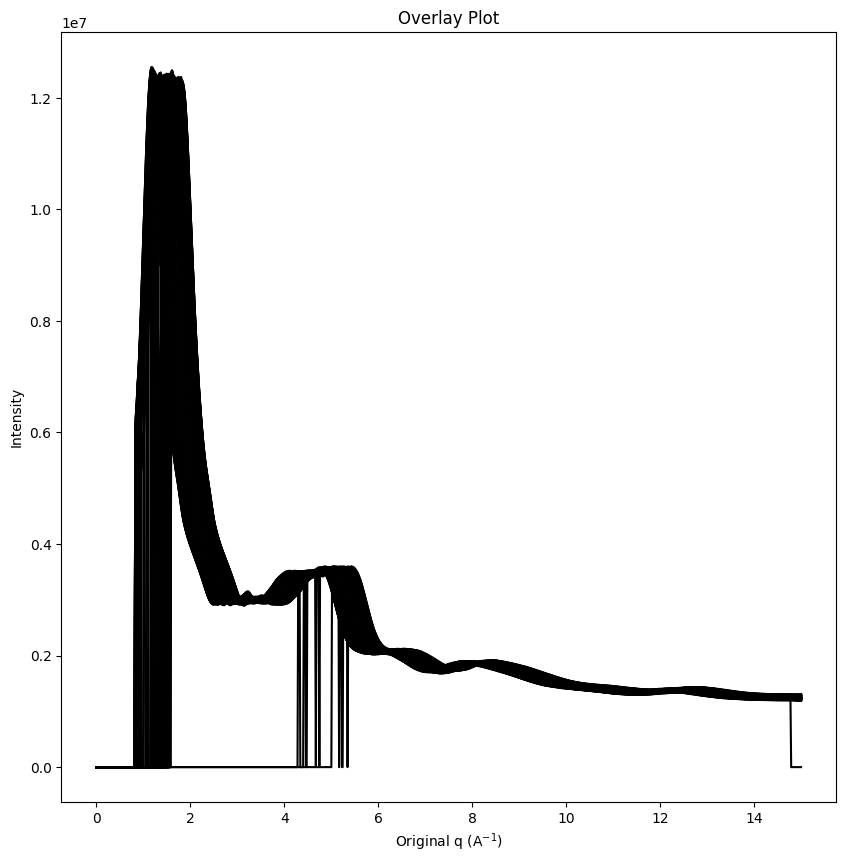

In [36]:
q, cryst_C_GST_SiO2_TM = rotate_and_integrate_maskdebug2(tm_circle, 5, .41794313, 1.22224e-11, resolution = 1000, mask = mask_12)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import fabio  # for reading EDF images
from pyFAI import AzimuthalIntegrator

# --- Load your 2D XRD image ---
# Replace 'your_image.edf' with the path to your synchrotron image file.
img_file = "your_image.edf"
img_data = fabio.open(img_file).data

# --- Setup the Azimuthal Integrator ---
# Update these calibration parameters with your experimental setup values.
ai = AzimuthalIntegrator(
    dist=200.0,      # sample-to-detector distance in mm (example value)
    poni1=1024,      # detector center x-coordinate in pixels
    poni2=1024,      # detector center y-coordinate in pixels
    pixel1=0.1,      # pixel size along axis 1 in mm
    pixel2=0.1       # pixel size along axis 2 in mm
)

# --- Define integration parameters ---
npt_rad = 1000  # number of points in the radial (q) direction
npt_azim = 360  # number of points in the azimuthal (chi) direction

# --- Perform the cake (2D azimuthal) integration ---
# By default, this returns a dictionary-like object with keys like "intensity", "q", and "chi".
result = ai.integrate2d(img_data, npt_rad, npt_azim)

# Extract the integrated intensity and coordinate arrays
intensity = result.intensity
q = result.q          # radial coordinate (in nm^-1 by default)
chi = result.chi      # azimuthal angle (in degrees)

# --- Plot the cake integration ---
plt.figure(figsize=(8, 6))
# 'extent' is defined as (xmin, xmax, ymax, ymin) to orient the plot as desired.
plt.imshow(intensity, extent=(chi.min(), chi.max(), q.max(), q.min()),
           aspect='auto', cmap='viridis')
plt.xlabel("Azimuthal angle, χ (deg)")
plt.ylabel("q (nm⁻¹)")
plt.title("Cake Integration Plot")
plt.colorbar(label="Intensity")
plt.show()


In [37]:
#Create a function that takes the combined image and integrates it using the azimuthal integrator and displays the 1D image
def integrate_image(combined_image, distance, wavelength, resolution = 3000, mask = None, center = None, show = False, radial_range = (0,15)):
    """
    This function integrates the combined image using the azimuthal integrator and displays the 1D image.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
    """
    #initialize the azimuthal integrator
    if center is None:
        center = (combined_image.shape[1]//2, combined_image.shape[0]//2)
     # Initialize the detector
    dete = pyFAI.detectors.Perkin()
    p1, p2, p3 = dete.calc_cartesian_positions()
    poni1 = read_poni_file(poni_file)[5]
    poni2 = read_poni_file(poni_file)[6]

    ai = AI.AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
    
    #integrate the combined image using the azimuthal integrator
    q, I = ai.integrate1d(combined_image, resolution, radial_range = radial_range, unit = 'q_A^-1', mask = mask)
    
    if show == True:
        #plot the 1D image
        plt.figure(figsize=(10, 10))
        plt.plot(q, I)
        plt.title("1D X-Ray Diffraction Image")
        plt.show()
    
    return q, I

In [60]:
qa, a = integrate_image(tm_circle, .41794313, 1.22224e-11, resolution = 1000, mask = mask_12)

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1, 1000)

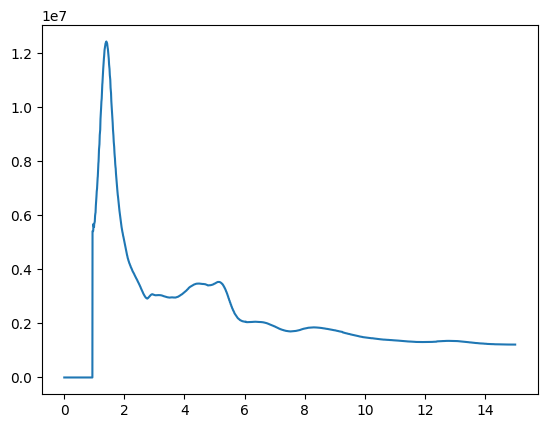

In [59]:
plt.plot(qa, a)
plt.plot(q, r_v2)

In [63]:
cryst_C_GST_SiO2_TM

0.000        5.000       10.000       15.000       20.000  \
0          0.000        0.000        0.000        0.000        0.000   
1          0.000        0.000        0.000        0.000        0.000   
2          0.000        0.000        0.000        0.000        0.000   
3          0.000        0.000        0.000        0.000        0.000   
4          0.000        0.000        0.000        0.000        0.000   
..           ...          ...          ...          ...          ...   
995  1185995.500  1187753.750  1198912.625  1202088.875  1202469.875   
996  1185880.750  1186702.125  1199430.625  1200847.750  1201425.250   
997  1186290.625  1185921.875  1199201.000  1200399.000  1201433.000   
998  1186593.500  1185239.125  1199139.375  1200455.375  1202303.875   
999  1185576.625  1185316.125  1197688.250  1199864.375  1201724.125   

          25.000       30.000       35.000       40.000       45.000  ...  \
0          0.000        0.000        0.000        0.000        0.000  ...   
1          0.000        0.000        0.000        0.000        0.000  ...   
2          0.000        0.000        0.000        0.000        0.000  ...   
3          0.000        0.000        0.000        0.000        0.000  ...   
4          0.000        0.000        0.000        0.000        0.000  ...   
..           ...          ...          ...          ...          ...  ...   
995  1203965.000  1215951.250  1223735.250  1224352.000  1230858.250  ...   
996  1203328.875  1215660.875  1223710.750  1224618.125  1230430.500  ...   
997  1203225.625  1214272.375  1223788.250  1223906.125  1230298.250  ...   
998  1202507.875  1213145.250  1223563.625  1224091.500  1229888.125  ...   
999  1202296.750  1214627.750  1224121.875  1223926.000  1229827.125  ...   

         310.000      315.000      320.000      325.000      330.000  \
0          0.000        0.000        0.000        0.000        0.000   
1          0.000        0.000        0.000        0.000        0.000   
2          0.000        0.000        0.000        0.000        0.000   
3          0.000        0.000        0.000        0.000        0.000   
4          0.000        0.000        0.000        0.000        0.000   
..           ...          ...          ...          ...          ...   
995  1225491.000  1217056.000  1209144.250  1216320.375  1212424.375   
996  1225823.625  1216622.125  1208461.875  1215989.500  1212607.750   
997  1225713.875  1217035.000  1207940.875  1215406.750  1212674.250   
998  1224677.500  1217626.375  1208127.500  1214832.500  1212258.875   
999  1223188.875  1216612.875  1208516.875  1214664.250  1212194.000   

         335.000      340.000      345.000  350.000      355.000  
0          0.000        0.000        0.000      0.0        0.000  
1          0.000        0.000        0.000      0.0        0.000  
2          0.000        0.000        0.000      0.0        0.000  
3          0.000        0.000        0.000      0.0        0.000  
4          0.000        0.000        0.000      0.0        0.000  
..           ...          ...          ...      ...          ...  
995  1212242.250  1210262.875  1207534.875      0.0  1188768.125  
996  1212716.375  1210404.875  1207269.375      0.0  1187519.500  
997  1212541.000  1209319.125  1206770.750      0.0  1186108.125  
998  1211588.000  1208274.500  1206481.875      0.0  1187453.625  
999  1211223.625  1208126.000  1205863.625      0.0  1188018.750  

[1000 rows x 72 columns]

In [47]:
transposed = cryst_C_GST_SiO2_TM.T

In [57]:
r_v2 = transposed[:1]

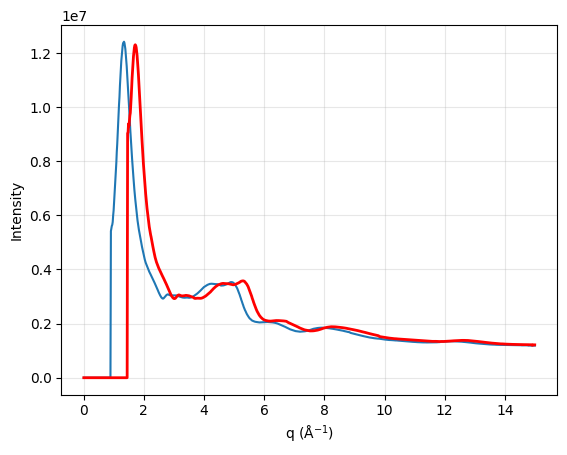

In [73]:
plt.plot(qa, a)

plt.plot(q, cryst_C_GST_SiO2_TM['180.000'], 'r-', linewidth=2)
plt.xlabel('q (Å$^{-1}$)')
plt.ylabel('Intensity')
plt.grid(True, alpha=0.3)
plt.show()

In [66]:
# Get the first angle column name
first_angle = cryst_C_GST_SiO2_TM.columns[0]

In [67]:
first_angle

'0.000'